In [1]:
import requests
from requests.auth import HTTPBasicAuth
import astropy.table as at
import matplotlib
from matplotlib.transforms import Bbox
from matplotlib.backends.backend_pdf import PdfPages
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.coordinates import Angle
import astropy.units as u
from astropy.visualization import PercentileInterval, AsinhStretch
from astroquery.mast import Catalogs
from astroquery.sdss import SDSS
from astroquery.simbad import Simbad
from astropy.table import Table

import pandas as pd

from PIL import Image
import os
import sys
import shutil
import glob
import json

import math

import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

import os
import sys
import annoy
from annoy import AnnoyIndex
import random



from IPython.display import display_markdown

from collections import Counter

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import cKDTree
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA

from alerce.core import Alerce
alerce = Alerce()

import antares_client

plt.style.use('fig_publication.mplstyle')
%config InlineBackend.figure_format = 'retina'  #for MacOS, make plots crisp

import sncosmo
import extinction

import warnings
warnings.filterwarnings("ignore")


In [2]:
smote_suffix = 'SMOTE_train_test_70-30_min14_kneighbors8'
dataset_bank_tns_df = pd.read_csv(f'../loci_dbs/alerce_cut/dataset_bank_tns_df_{smote_suffix}.csv.gz', compression='gzip', index_col=0)
dataset_bank_tns_df

,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,feature_kurtosis_magn_r,feature_linear_fit_slope_magn_r,...,rApMag_rKronMag,iApMag_iKronMag,zApMag_zKronMag,yApMag_yKronMag,7DCD,dist/DLR,has_tns,tns_cls,spec_z,report_group
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF19abvhaqq,0.391695,0.368108,0.375000,0.000000,0.395856,0.783390,0.723513,0.435022,-0.830757,0.000424,...,0.493101,0.594500,0.698700,0.587200,43.259193,0.629409,Yes_TNS,None,-99.00000,ZTF
ZTF21aaswtkh,0.356501,0.355052,0.300000,0.000000,0.321765,0.713001,0.551514,0.300600,0.231450,0.000459,...,-0.026499,-0.157400,-0.083000,-0.157801,8.971037,0.034890,No_TNS,None,-99.00000,None
ZTF18abscghc,0.224128,0.290376,0.400000,0.000000,0.345730,0.448256,0.448256,0.169133,2.276334,0.003358,...,0.446798,0.523201,0.552601,0.673201,2.667939,0.236800,No_TNS,None,-99.00000,None
ZTF21abjpjcn,0.392974,0.806768,0.142857,0.142857,0.316430,0.785948,0.671357,0.204642,4.390367,-0.040870,...,-0.050900,0.008600,-0.069901,0.001501,14.958282,0.031570,Yes_TNS,None,-99.00000,ALeRCE
ZTF21aarhzdh,0.908470,0.317764,0.263158,0.000000,0.397708,1.816940,1.555440,0.847626,-0.448936,0.021725,...,0.554300,0.658100,0.554300,0.594801,22.116211,1.116821,Yes_TNS,SN Ia,0.06975,ALeRCE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF20acupxyy,0.630460,1.074418,0.400000,0.000000,0.457814,1.260920,1.047050,0.832848,-1.744178,0.027233,...,-0.096199,-0.062302,-0.075001,-0.101900,14.188714,2.588904,Yes_TNS,None,-99.00000,ZTF
ZTF21aarzxnb,0.121910,0.562210,0.142857,0.000000,0.376162,0.243820,0.218541,0.099431,1.578408,0.012642,...,0.172100,0.201801,-0.015202,-0.012701,0.801429,0.175727,Yes_TNS,None,-99.00000,ALeRCE
ZTF18acsxjhc,0.926579,1.119445,0.303797,0.037975,0.349061,1.801871,1.069640,0.539695,-0.012415,0.001636,...,0.748601,0.825200,0.762100,0.754800,42.918356,0.008771,Yes_TNS,None,-99.00000,iPTF


In [3]:
def calculate_band_mw_extinctions(bands):
    # modified from https://github.com/LSSTDESC/parsnip/blob/1a866fb8f75572e5a927588d1e55013ece312624/parsnip/instruments.py#L47
    band_mw_extinctions = []
    for band_name in bands:
        # Check if we should be correcting the extinction for this band.
        band = sncosmo.get_bandpass(band_name)
        band_mw_extinctions.append(extinction.fm07(np.array([band.wave_eff]), 3.1)[0])
    band_mw_extinctions = np.array(band_mw_extinctions)
    return band_mw_extinctions

In [4]:
calculate_band_mw_extinctions(['ztfg', 'ztfr'])

array([3.68860042, 2.47630754])

In [5]:
def get_extinction_corrected_mags_pb(band_extinction_curve, mwebv, magnitudes):
    from extinction import fm07, remove
    # Convert magnitudes to fluxes
    fluxes = 10**(-0.4 * (magnitudes-27.5))

    # Calculate the extinction correction
    extinction_correction = remove(band_extinction_curve, mwebv)

    # Apply the extinction correction to the fluxes
    corrected_fluxes = fluxes * 10**(0.4 * extinction_correction)

    # Convert corrected fluxes back to magnitudes
    corrected_magnitudes = 27.5 -2.5 * np.log10(corrected_fluxes)

    return corrected_magnitudes

In [6]:
def return_salt3_fit_params(z, time_arr, pb_arr, flux_arr, fluxerr_arr):
    model = sncosmo.Model(source='salt3')
    #model.set(z=z)
    # Columns need to be: time, band, flux, fluxerr, zp, zpsys
    #https://sncosmo.readthedocs.io/en/latest/photdata.html
    lc_df = pd.DataFrame(zip(time_arr, pb_arr, flux_arr, fluxerr_arr), 
                         columns=["time", "band", "flux", "flux_err"])
    # Change passbands to those in registry (g == ps1::g)
    band_map = {'g': 'ztfg',
                'R': 'ztfr',
               }
    lc_df = lc_df.replace({"band": band_map})
    lc_df['zp'] = 27.5
    lc_df['zpsys'] = 'ab'

    lc_Table = Table.from_pandas(lc_df) # Astropy Table for SALT3
    #print(lc_Table) 

    try:
        res, fitted_model = sncosmo.fit_lc(lc_Table, model,
                                  ['z', 't0', 'x0', 'x1', 'c'],
                                          bounds={'z':(0.0, 0.3)})
        param_dict = dict(zip(res['param_names'], res['parameters']))
        # https://github.com/davecoulter/YSE_PZ/blob/21355c5f646eb7a30ef9eda4c886274742e6a087/YSE_App/view_utils.py#LL1099C59-L1099C102
        param_dict.update(mB = 10.635-2.5*np.log10(param_dict['x0'])) 
        print(param_dict)
        model.set(z=param_dict['z'],t0=param_dict['t0'],
              x1=param_dict['x1'],c=param_dict['c'],x0=param_dict['x0'])

    except Exception as e:
        print(e)
        
    return lc_df, param_dict

In [7]:
def return_salt3_fit_params_force_z(z, time_arr, pb_arr, flux_arr, fluxerr_arr):
    model = sncosmo.Model(source='salt3')
    model.set(z=z)
    # Columns need to be: time, band, flux, fluxerr, zp, zpsys
    #https://sncosmo.readthedocs.io/en/latest/photdata.html
    lc_df = pd.DataFrame(zip(time_arr, pb_arr, flux_arr, fluxerr_arr), 
                         columns=["time", "band", "flux", "flux_err"])
    # Change passbands to those in registry (g == ps1::g)
    band_map = {'g': 'ztfg',
                'R': 'ztfr',
               }
    lc_df = lc_df.replace({"band": band_map})
    lc_df['zp'] = 27.5
    lc_df['zpsys'] = 'ab'

    lc_Table = Table.from_pandas(lc_df) # Astropy Table for SALT3
    #print(lc_Table) 

    try:
        res, fitted_model = sncosmo.fit_lc(lc_Table, model,
                                  ['t0', 'x0', 'x1', 'c'])
        param_dict = dict(zip(res['param_names'], res['parameters']))
        # https://github.com/davecoulter/YSE_PZ/blob/21355c5f646eb7a30ef9eda4c886274742e6a087/YSE_App/view_utils.py#LL1099C59-L1099C102
        param_dict.update(mB = 10.635-2.5*np.log10(param_dict['x0'])) 
        print(param_dict)
        model.set(z=param_dict['z'],t0=param_dict['t0'],
              x1=param_dict['x1'],c=param_dict['c'],x0=param_dict['x0'])

    except Exception as e:
        print(e)
        
    return lc_df, param_dict

In [8]:
def _calculate_band_mw_extinctions(bands=['ztfg', 'ztfr']):
        # modified from https://github.com/LSSTDESC/parsnip/blob/1a866fb8f75572e5a927588d1e55013ece312624/parsnip/instruments.py#L47
        band_mw_extinctions = []
        for band_name in bands:
            # Check if we should be correcting the extinction for this band.
            band = sncosmo.get_bandpass(band_name)
            band_mw_extinctions.append(extinction.fm07(np.array([band.wave_eff]), 3.1)[0])
            print(band_name, band.wave_eff)
        band_mw_extinctions = np.array(band_mw_extinctions)
        return band_mw_extinctions

In [9]:
band_mw_extinctions = _calculate_band_mw_extinctions()

ztfg 4813.948048935322
ztfr 6421.814890148709


In [10]:
def get_magerr_from_mag_pb(magnitude_errors, pbname):
    # Observed magnitudes and magnitude errors
    mag_errs = np.array(magnitude_errors)

    # Extinction in magnitudes at the wavelength of interest
    if pbname == 'g': A_lambda = 0.12910101
    elif pbname == 'R': A_lambda = 0.08667076

    # Extinction correction factor
    ext_factor = 10**(0.4 * A_lambda)

    # Calculate corrected magnitude errors
    mag_corr_errs = mag_errs * ext_factor

    return mag_corr_errs

In [11]:
def get_extinction_corrected_mags(mwebv, magnitudes, pbs):
    from extinction import fm07, remove
    
    def _calculate_band_mw_extinctions(bands=['ztfg', 'ztfr']):
        # modified from https://github.com/LSSTDESC/parsnip/blob/1a866fb8f75572e5a927588d1e55013ece312624/parsnip/instruments.py#L47
        band_mw_extinctions = []
        for band_name in bands:
            # Check if we should be correcting the extinction for this band.
            band = sncosmo.get_bandpass(band_name)
            band_mw_extinctions.append(extinction.fm07(np.array([band.wave_eff]), 3.1)[0])
            #print(band_name, band.wave_eff)
        band_mw_extinctions = np.array(band_mw_extinctions)
        return band_mw_extinctions
    
    band_mw_extinctions = _calculate_band_mw_extinctions()
    
    corrected_fluxes, corrected_magnitudes, A_lambdas = [], [], []
    for mag, pb in zip(magnitudes, pbs):
        if pb == 'g': 
            band_mw_ext = band_mw_extinctions[0]
            A_lambda = extinction.fm07(np.array([4813.948048935322]), 3.1) * mwebv
        elif pb == 'R': 
            band_mw_ext = band_mw_extinctions[1]
            A_lambda = extinction.fm07(np.array([6421.814890148709]), 3.1) * mwebv
            
        # Convert magnitudes to fluxes
        flux = 10**(-0.4 * (mag-27.5))

        # Calculate the extinction correction
        extinction_correction = remove(band_mw_ext, mwebv)

        # Apply the extinction correction to the fluxes
        corrected_flux = flux * 10**(0.4 * extinction_correction)
        corrected_fluxes.append(corrected_flux)

        # Convert corrected fluxes back to magnitudes
        corrected_mag = 27.5 -2.5 * np.log10(corrected_flux)
        corrected_magnitudes.append(corrected_mag)
        
        A_lambdas.append(A_lambda[0])
    
    return np.array(corrected_fluxes), np.array(corrected_magnitudes), np.array(A_lambdas)

# ZTF21aaublej

{'z': 0.041, 't0': 59330.48913404568, 'x0': 0.0024732202829143312, 'x1': -0.21404214661362636, 'c': 0.030128404693020187, 'mB': 17.151843001258506}
{'z': 0.041, 't0': 59330.56736112155, 'x0': 0.007278108220140617, 'x1': -0.11346896832787179, 'c': -0.5507092041774219, 'mB': 15.979953727651981}


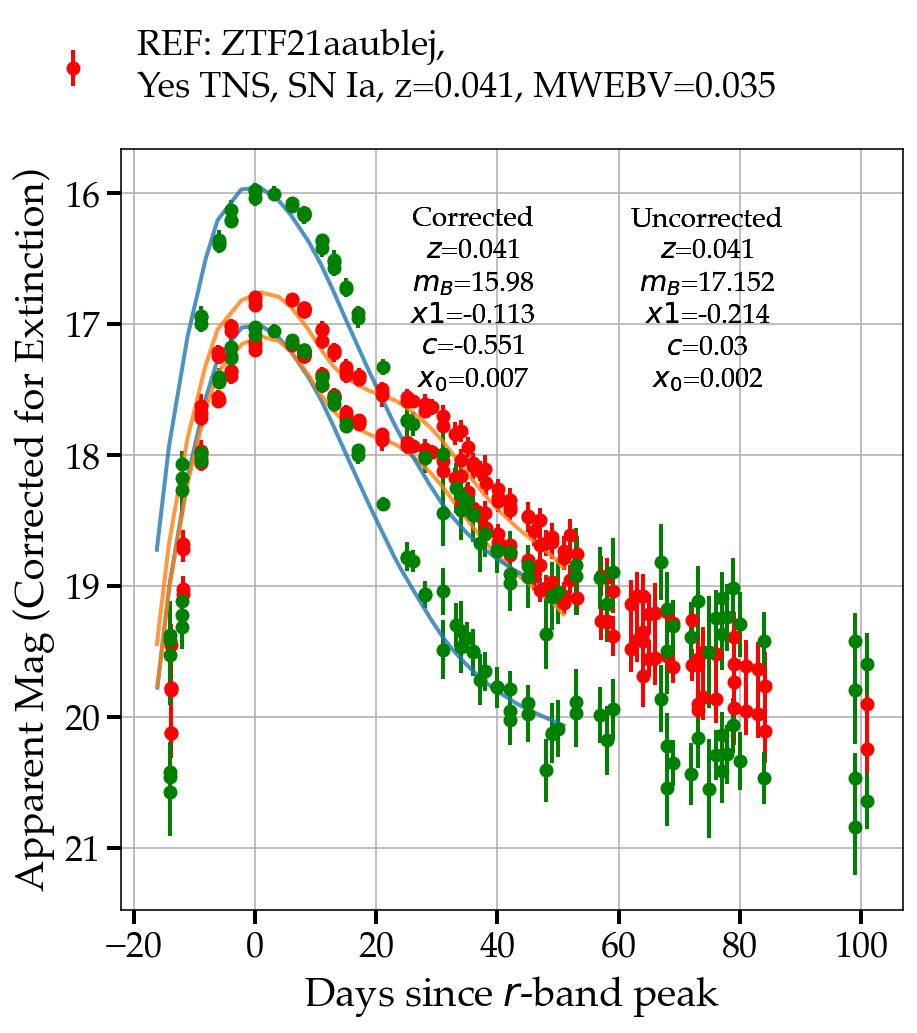

CPU times: user 3.37 s, sys: 344 ms, total: 3.72 s
Wall time: 2.87 s


In [12]:
%%time

ztf_id_ref = "ZTF21aaublej"
mwebv = 0.035
z= 0.041

host_df_ztf_id_l, host_df_ra_l, host_df_dec_l = [], [], []

#ztf_id_ref = ztf_id_ref #idx_arr[result_id[0]]
ref_info = antares_client.search.get_by_ztf_object_id(ztf_object_id=ztf_id_ref)

df_ref = ref_info.timeseries.to_pandas()

has_tns_ref = dataset_bank_tns_df.loc[ztf_id_ref].has_tns.replace('_', ' ')
tns_cls_ref = dataset_bank_tns_df.loc[ztf_id_ref].tns_cls
spec_z_ref = dataset_bank_tns_df.loc[ztf_id_ref].spec_z

# ra_ref = dataset_bank_orig_host_ra_dec.loc[ztf_id_ref].raMean
# dec_ref = dataset_bank_orig_host_ra_dec.loc[ztf_id_ref].decMean  

fig, ax = plt.subplots(figsize=(7,7))
#plt.gca().invert_yaxis()

df_ref_g = df_ref[(df_ref.ant_passband == 'g') & (~df_ref.ant_mag.isna())]
df_ref_r = df_ref[(df_ref.ant_passband == 'R') & (~df_ref.ant_mag.isna())]

mjd_idx_at_min_mag_r_ref = df_ref_r[['ant_mag']].reset_index().idxmin().ant_mag
mjd_idx_at_min_mag_g_ref = df_ref_g[['ant_mag']].reset_index().idxmin().ant_mag

# Uncorrected
ax.errorbar(x=df_ref_r.ant_mjd-df_ref_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_ref], y=df_ref_r.ant_mag, yerr=df_ref_r.ant_magerr, fmt='o', c='r')
ax.errorbar(x=df_ref_g.ant_mjd-df_ref_g.ant_mjd.iloc[mjd_idx_at_min_mag_r_ref], y=df_ref_g.ant_mag, yerr=df_ref_g.ant_magerr, fmt='o', c='g')

# apply SALT3 fit
time_arr_ref = df_ref[(~df_ref.ant_mag.isna())].ant_mjd.values
pb_arr_ref = df_ref[(~df_ref.ant_mag.isna())].ant_passband.values
mag_arr_ref = df_ref[(~df_ref.ant_mag.isna())].ant_mag.values
flux_arr_ref = 10**(-0.4 * (mag_arr_ref-27.5))
flux_corrected_arr_ref, mag_corrected_arr_ref, A_lambda_arr = get_extinction_corrected_mags(mwebv=mwebv, magnitudes=mag_arr_ref, pbs=pb_arr_ref)
magerr_arr_ref = df_ref[(~df_ref.ant_mag.isna())].ant_magerr.values
#fluxerr_corrected_arr_ref_notreal, magerr_corrected_arr_ref, A_lambda_arr = get_extinction_corrected_mags(mwebv=mwebv, magnitudes=magerr_arr_ref, pbs=pb_arr_ref)
fluxerr_arr_ref = (magerr_arr_ref*flux_arr_ref)/1.0857
fluxerr_corrected_arr_ref = (magerr_arr_ref*flux_corrected_arr_ref)/1.0857 #flux_arr_ref * 10**(0.4 * A_lambda_arr)
lc_df, param_dict = return_salt3_fit_params_force_z(z=z, time_arr=time_arr_ref, pb_arr=pb_arr_ref, flux_arr=flux_arr_ref, fluxerr_arr=fluxerr_arr_ref)
lc_df_corrected, param_dict_corrected = return_salt3_fit_params_force_z(z=z, time_arr=time_arr_ref, pb_arr=pb_arr_ref, flux_arr=flux_corrected_arr_ref, fluxerr_arr=fluxerr_corrected_arr_ref)


for i,f in enumerate(np.unique(lc_df['band'])):
    z= round(param_dict['z'], 3)
    t0= round(param_dict['t0'], 3)
    mB= round(param_dict['mB'], 3)
    x1= round(param_dict['x1'], 3)
    c= round(param_dict['c'], 3)
    x0= round(param_dict['x0'], 3)

    # careful about zpsys!
    model = sncosmo.Model(source='salt3')
    model.set(z=z,t0=param_dict['t0'], x1=param_dict['x1'],c=param_dict['c'],x0=param_dict['x0'])
    salt3flux = model.bandflux(f, lc_df['time'], zp=27.5, zpsys='AB')
    salt3mag = 27.5 -2.5 * np.log10(salt3flux)
    ax.plot(lc_df['time']-t0,salt3mag,color='C%i'%i, alpha=0.8, linewidth=2)

    ax.text(0.75, 0.80, "Uncorrected"+'\n'+ fr"$z$={z}"+'\n'+ fr"$m_B$={mB}"+'\n'+ fr"$x1$={x1}"+'\n'+ fr"$c$={c}"+'\n'+ fr"$x_0$={x0}",#+'\n'+ fr"$m_{pkflt}$={pkmag}", 
            horizontalalignment='center', 
             verticalalignment='center', 
             transform=ax.transAxes,
             fontsize=14)

# Corrected
corrected_mags_r = get_extinction_corrected_mags_pb(band_extinction_curve=calculate_band_mw_extinctions(['ztfr'])[0], 
                                                 mwebv=mwebv, magnitudes=df_ref_r.ant_mag.values)
corrected_mags_g = get_extinction_corrected_mags_pb(band_extinction_curve=calculate_band_mw_extinctions(['ztfg'])[0], 
                                                 mwebv=mwebv, magnitudes=df_ref_g.ant_mag.values)
corrected_magerrs_r = get_magerr_from_mag_pb(magnitude_errors=df_ref_r.ant_magerr, pbname='R')
corrected_magerrs_g = get_magerr_from_mag_pb(magnitude_errors=df_ref_g.ant_magerr, pbname='g')

ax.errorbar(x=df_ref_r.ant_mjd-df_ref_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_ref], y=corrected_mags_r, yerr=corrected_magerrs_r, fmt='o', c='r',
           label=f'REF: {ztf_id_ref}, \n{has_tns_ref},\t{tns_cls_ref},\tz={round(spec_z_ref, 3)}, MWEBV={mwebv}')
ax.errorbar(x=df_ref_g.ant_mjd-df_ref_g.ant_mjd.iloc[mjd_idx_at_min_mag_r_ref], y=corrected_mags_g, yerr=corrected_magerrs_g, fmt='o', c='g')

for i,f in enumerate(np.unique(lc_df['band'])):
    z= round(param_dict_corrected['z'], 3)
    t0= round(param_dict_corrected['t0'], 3)
    mB= round(param_dict_corrected['mB'], 3)
    x1= round(param_dict_corrected['x1'], 3)
    c= round(param_dict_corrected['c'], 3)
    x0= round(param_dict_corrected['x0'], 3)

    # careful about zpsys!
    model = sncosmo.Model(source='salt3')
    model.set(z=z,t0=param_dict_corrected['t0'], x1=param_dict_corrected['x1'],c=param_dict_corrected['c'],x0=param_dict_corrected['x0'])
    salt3flux = model.bandflux(f, lc_df['time'], zp=27.5, zpsys='AB')
    salt3mag = 27.5 -2.5 * np.log10(salt3flux)
    ax.plot(lc_df['time']-t0,salt3mag,color='C%i'%i, alpha=0.8, linewidth=2)

    ax.text(0.45, 0.80, "Corrected"+'\n'+ fr"$z$={z}"+'\n'+ fr"$m_B$={mB}"+'\n'+ fr"$x1$={x1}"+'\n'+ fr"$c$={c}"+'\n'+ fr"$x_0$={x0}",#+'\n'+ fr"$m_{pkflt}$={pkmag}", 
            horizontalalignment='center', 
             verticalalignment='center', 
             transform=ax.transAxes,
             fontsize=14)

plt.ylabel('Apparent Mag (Corrected for Extinction)')
plt.xlabel('Days since $r$-band peak')
plt.legend(frameon=False,
           bbox_to_anchor=(0.88,1.2),
           ncol=1,
           prop={'size': 18})

plt.gca().invert_yaxis()
plt.grid(True)

folder_path = f"../figures/salt3/"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

plt.savefig(f'../figures/salt3/{ztf_id_ref}_corrected_vs_uncorrected.jpg', dpi=300, bbox_inches='tight')
plt.show()

{'z': 0.03232401218709555, 't0': 59330.5016345637, 'x0': 0.007469820076528346, 'x1': -0.0683170975693718, 'c': -0.5399189693460049, 'mB': 15.951724646971531}
###########
0 ('ZTF21abbkefe', 0.042, 0.042, 'SN Ia')
{'z': 0.042, 't0': 59363.1412368437, 'x0': 0.006872891175900862, 'x1': 0.09610188565274674, 'c': -0.6425402242739143, 'mB': 16.04215133143931}
1 ('ZTF20abqaqgv', 0.05, 0.134, 'SN Ia')
{'z': 0.05, 't0': 59079.14325339346, 'x0': 0.12318132990455392, 'x1': 0.6516935321144942, 'c': -1.8777854444240254, 'mB': 12.908637778600054}
2 ('ZTF20acucbek', 0.045, 0.011, 'SN Ia')
{'z': 0.045, 't0': 59194.84869817185, 'x0': 0.004517599013551343, 'x1': 0.08228093837135032, 'c': -0.24587281127105118, 'mB': 16.497730800255844}
3 ('ZTF20aczgoml', 0.021, 0.013, 'SN Ia')
{'z': 0.021, 't0': 59220.40687463262, 'x0': 0.0032423026562687462, 'x1': 1.2991136196744613, 'c': -0.16395666452030389, 'mB': 16.857866119760985}
4 ('ZTF21aaabaey', 0.039, 0.035, 'SN Ia')
{'z': 0.039, 't0': 59227.8950838783, 'x0': 0

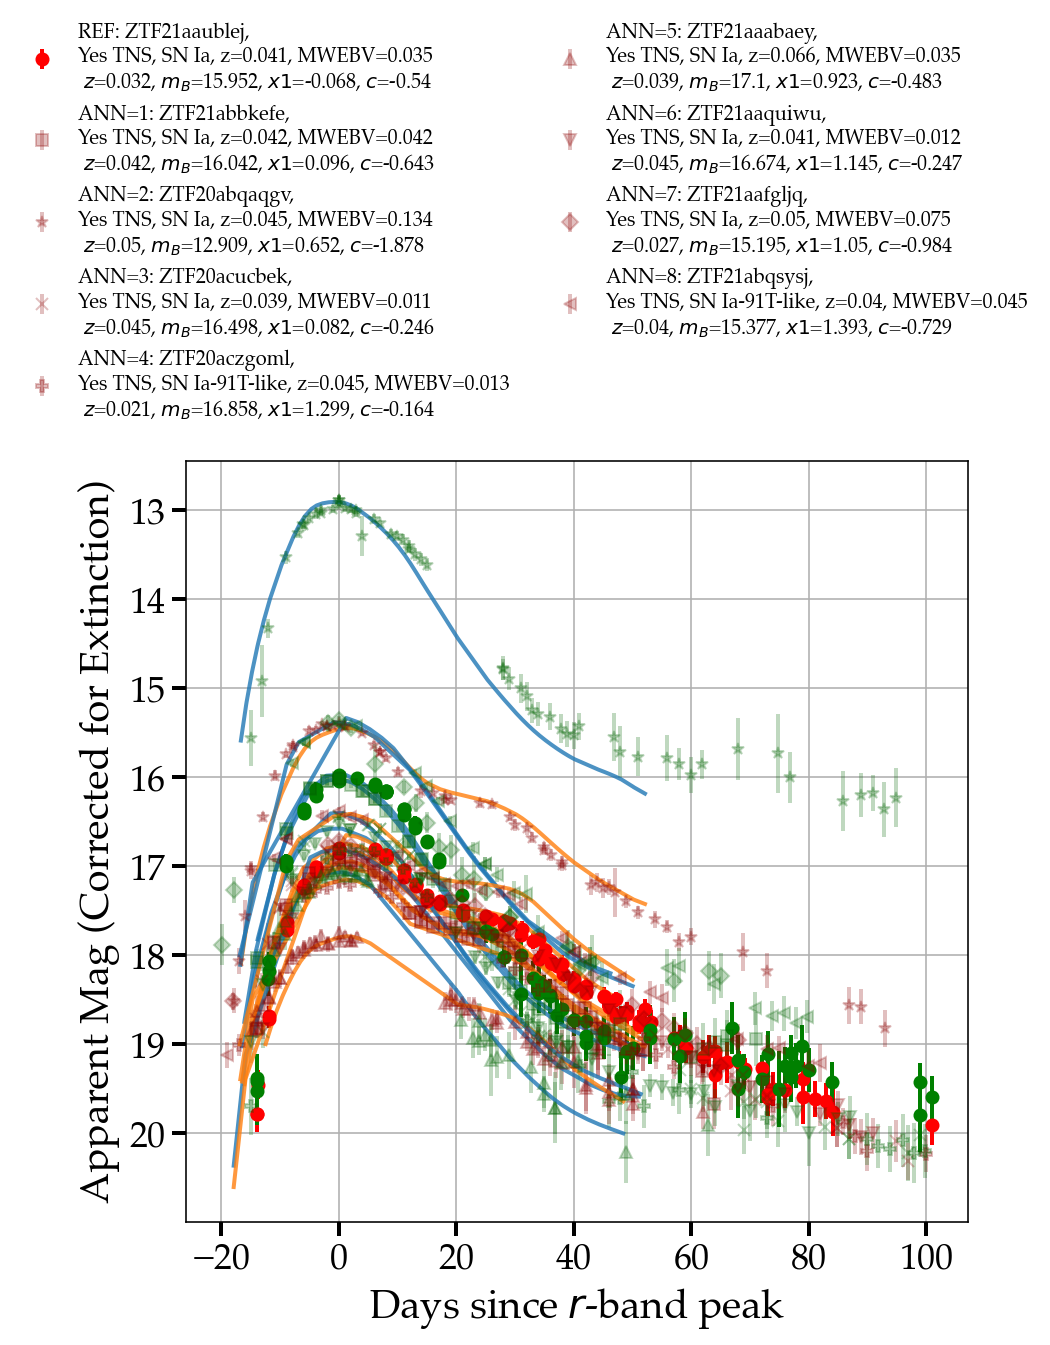

CPU times: user 10.6 s, sys: 1.38 s, total: 12 s
Wall time: 8.68 s


In [13]:
%%time

ztf_id_ref = "ZTF21aaublej"
mwebv = 0.035
z= 0.041
mB_l = []

host_df_ztf_id_l, host_df_ra_l, host_df_dec_l = [], [], []

ref_info = antares_client.search.get_by_ztf_object_id(ztf_object_id=ztf_id_ref)

df_ref = ref_info.timeseries.to_pandas()

has_tns_ref = dataset_bank_tns_df.loc[ztf_id_ref].has_tns.replace('_', ' ')
tns_cls_ref = dataset_bank_tns_df.loc[ztf_id_ref].tns_cls
spec_z_ref = dataset_bank_tns_df.loc[ztf_id_ref].spec_z

fig, ax = plt.subplots(figsize=(7,7))
#plt.gca().invert_yaxis()

df_ref_g = df_ref[(df_ref.ant_passband == 'g') & (~df_ref.ant_mag.isna())]
df_ref_r = df_ref[(df_ref.ant_passband == 'R') & (~df_ref.ant_mag.isna())]

mjd_idx_at_min_mag_r_ref = df_ref_r[['ant_mag']].reset_index().idxmin().ant_mag
mjd_idx_at_min_mag_g_ref = df_ref_g[['ant_mag']].reset_index().idxmin().ant_mag


# apply SALT3 fit
time_arr_ref = df_ref[(~df_ref.ant_mag.isna())].ant_mjd.values
pb_arr_ref = df_ref[(~df_ref.ant_mag.isna())].ant_passband.values
mag_arr_ref = df_ref[(~df_ref.ant_mag.isna())].ant_mag.values
flux_arr_ref = 10**(-0.4 * (mag_arr_ref-27.5))
flux_corrected_arr_ref, mag_corrected_arr_ref, A_lambda_arr = get_extinction_corrected_mags(mwebv=mwebv, magnitudes=mag_arr_ref, pbs=pb_arr_ref)
magerr_arr_ref = df_ref[(~df_ref.ant_mag.isna())].ant_magerr.values
#fluxerr_corrected_arr_ref_notreal, magerr_corrected_arr_ref, A_lambda_arr = get_extinction_corrected_mags(mwebv=mwebv, magnitudes=magerr_arr_ref, pbs=pb_arr_ref)
fluxerr_arr_ref = (magerr_arr_ref*flux_arr_ref)/1.0857
fluxerr_corrected_arr_ref = (magerr_arr_ref*flux_corrected_arr_ref)/1.0857 #flux_arr_ref * 10**(0.4 * A_lambda_arr)
lc_df_corrected_ref, param_dict_corrected_ref = return_salt3_fit_params(z=z, time_arr=time_arr_ref, pb_arr=pb_arr_ref, flux_arr=flux_corrected_arr_ref, fluxerr_arr=fluxerr_corrected_arr_ref)

# Corrected
corrected_mags_r = get_extinction_corrected_mags_pb(band_extinction_curve=calculate_band_mw_extinctions(['ztfr'])[0], 
                                                 mwebv=mwebv, magnitudes=df_ref_r.ant_mag.values)
corrected_mags_g = get_extinction_corrected_mags_pb(band_extinction_curve=calculate_band_mw_extinctions(['ztfg'])[0], 
                                                 mwebv=mwebv, magnitudes=df_ref_g.ant_mag.values)
corrected_magerrs_r = get_magerr_from_mag_pb(magnitude_errors=df_ref_r.ant_magerr, pbname='R')
corrected_magerrs_g = get_magerr_from_mag_pb(magnitude_errors=df_ref_g.ant_magerr, pbname='g')

for i,f in enumerate(np.unique(lc_df_corrected_ref['band'])):
    z= round(param_dict_corrected_ref['z'], 3)
    t0= round(param_dict_corrected_ref['t0'], 3)
    mB= round(param_dict_corrected_ref['mB'], 3)
    x1= round(param_dict_corrected_ref['x1'], 3)
    c= round(param_dict_corrected_ref['c'], 3)
    x0= round(param_dict_corrected_ref['x0'], 3)

    # careful about zpsys!
    model = sncosmo.Model(source='salt3')
    model.set(z=z,t0=param_dict_corrected_ref['t0'], x1=param_dict_corrected_ref['x1'],c=param_dict_corrected_ref['c'],x0=param_dict_corrected_ref['x0'])
    salt3flux = model.bandflux(f, lc_df_corrected_ref['time'], zp=27.5, zpsys='AB')
    salt3mag = 27.5 -2.5 * np.log10(salt3flux)
    ax.plot(lc_df_corrected_ref['time']-t0,salt3mag,color='C%i'%i, alpha=0.8, linewidth=2)

    #ax.text(0.45, 0.80, "Corrected"+'\n'+ fr"$z$={z}"+'\n'+ fr"$t_0$={t0}"+'\n'+ fr"$x1$={x1}"+'\n'+ fr"$c$={c}"+'\n'+ fr"$x_0$={x0}",#+'\n'+ fr"$m_{pkflt}$={pkmag}", 
    #        horizontalalignment='center', 
    #         verticalalignment='center', 
    #         transform=ax.transAxes,
    #         fontsize=14)
    
ax.errorbar(x=df_ref_r.ant_mjd-df_ref_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_ref], y=corrected_mags_r, yerr=corrected_magerrs_r, fmt='o', c='r',
           label=f"REF: {ztf_id_ref}, \n{has_tns_ref},\t{tns_cls_ref},\tz={round(spec_z_ref, 3)}, MWEBV={mwebv}\n $z$={z}, $m_B$={mB}, $x1$={x1}, $c$={c}")
ax.errorbar(x=df_ref_g.ant_mjd-df_ref_g.ant_mjd.iloc[mjd_idx_at_min_mag_g_ref], y=corrected_mags_g, yerr=corrected_magerrs_g, fmt='o', c='g')

mB_l.append(param_dict_corrected_ref['mB'])
print("###########")
    
    
markers = ['s', '*', 'x', 'P', '^', 'v', 'D', '<', '>', '8', 'p', 'x'] 
consts = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36] 

ztf_id_l = ["ZTF21abbkefe", "ZTF20abqaqgv", "ZTF20acucbek", "ZTF20aczgoml", "ZTF21aaabaey",
            "ZTF21aaquiwu", "ZTF21aafgljq", "ZTF21abqsysj"]
z_l = [0.042, 0.05, 0.045, 0.021, 0.039, 0.045, 0.027, 0.04]
mwebv_l = [0.042, 0.134, 0.011, 0.013, 0.035, 
           0.012, 0.075, 0.045]
spec_cls_l = ["SN Ia", "SN Ia", "SN Ia", "SN Ia", "SN Ia", "SN Ia-91T-like", "SN Ia", "SN Ia-91T-like"]


for num, (ztf_id_knn, z_knn, mwebv_knn, spec_cls_knn) in enumerate(zip(ztf_id_l, z_l, mwebv_l, spec_cls_l)):
    print(num, (ztf_id_knn, z_knn, mwebv_knn, spec_cls_knn))
    ztf_id_ann = ztf_id_knn

    try:
        l_info = antares_client.search.get_by_ztf_object_id(ztf_object_id=ztf_id_ann)
        df_knn = l_info.timeseries.to_pandas()
    except: continue  
    
    has_tns_knn = dataset_bank_tns_df.loc[ztf_id_ann].has_tns.replace('_', ' ')
    tns_cls_knn = dataset_bank_tns_df.loc[ztf_id_ann].tns_cls
    spec_z_knn = dataset_bank_tns_df.loc[ztf_id_ann].spec_z


    df_knn_g = df_knn[(df_knn.ant_passband == 'g') & (~df_knn.ant_mag.isna())]
    df_knn_r = df_knn[(df_knn.ant_passband == 'R') & (~df_knn.ant_mag.isna())]
    
    mjd_idx_at_min_mag_r_knn = df_knn_r[['ant_mag']].reset_index().idxmin().ant_mag
    mjd_idx_at_min_mag_g_knn = df_knn_g[['ant_mag']].reset_index().idxmin().ant_mag
    
    # apply SALT3 fit
    time_arr_knn = df_knn[(~df_knn.ant_mag.isna())].ant_mjd.values
    pb_arr_knn = df_knn[(~df_knn.ant_mag.isna())].ant_passband.values
    mag_arr_knn = df_knn[(~df_knn.ant_mag.isna())].ant_mag.values
    flux_arr_knn = 10**(-0.4 * (mag_arr_knn-27.5))
    flux_corrected_arr_knn, mag_corrected_arr_knn, A_lambda_arr_knn = get_extinction_corrected_mags(mwebv=mwebv_knn, magnitudes=mag_arr_knn, pbs=pb_arr_knn)
    magerr_arr_knn = df_knn[(~df_knn.ant_mag.isna())].ant_magerr.values
    fluxerr_corrected_arr_knn_notreal, magerr_corrected_arr_knn, A_lambda_arr_knn = get_extinction_corrected_mags(mwebv=mwebv_knn, magnitudes=magerr_arr_knn, pbs=pb_arr_knn)
    fluxerr_arr_knn = (magerr_arr_knn*flux_arr_knn)/1.0857
    fluxerr_corrected_arr_knn = (magerr_arr_knn*flux_corrected_arr_knn)/1.0857 #flux_arr_ref * 10**(0.4 * A_lambda_arr)
    # Corrected
    corrected_mags_r_knn = get_extinction_corrected_mags_pb(band_extinction_curve=calculate_band_mw_extinctions(['ztfr'])[0], 
                                                     mwebv=mwebv_knn, magnitudes=df_knn_r.ant_mag.values)
    corrected_mags_g_knn = get_extinction_corrected_mags_pb(band_extinction_curve=calculate_band_mw_extinctions(['ztfg'])[0], 
                                                     mwebv=mwebv_knn, magnitudes=df_knn_g.ant_mag.values)
    #print("corrected_mags_g_knn", corrected_mags_g_knn, len(corrected_mags_g_knn))
    corrected_magerrs_r_knn = get_magerr_from_mag_pb(magnitude_errors=df_knn_r.ant_magerr, pbname='R')
    corrected_magerrs_g_knn = get_magerr_from_mag_pb(magnitude_errors=df_knn_g.ant_magerr, pbname='g')
    
    if spec_cls_knn.startswith("SN Ia"):
        try:
            lc_df_corrected_knn, param_dict_corrected_knn = return_salt3_fit_params_force_z(z=z_knn, time_arr=time_arr_knn, pb_arr=pb_arr_knn, flux_arr=flux_corrected_arr_knn, fluxerr_arr=fluxerr_corrected_arr_knn)
        except: 
            print("Bad fit. Continue...")   
            ax.errorbar(x=df_knn_r.ant_mjd-df_knn_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_knn], y=corrected_mags_r_knn, yerr=corrected_magerrs_r_knn, fmt=markers[num], c='darkred', alpha=0.25, 
               label=f"ANN={num+1}: {ztf_id_knn}, \n{has_tns_knn},\t{tns_cls_knn},\tz={round(spec_z_knn, 3)}, MWEBV={mwebv_knn}\n $z$=-99, $m_B$=-99, $x1$=-99, $c$=-99")
            ax.errorbar(x=df_knn_g.ant_mjd-df_knn_g.ant_mjd.iloc[mjd_idx_at_min_mag_g_knn], y=corrected_mags_g_knn, yerr=corrected_magerrs_g_knn, fmt=markers[num], c='darkgreen', alpha=0.25)
            continue
    
    else:
        ax.errorbar(x=df_knn_r.ant_mjd-df_knn_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_knn], y=corrected_mags_r_knn, yerr=corrected_magerrs_r_knn, fmt=markers[num], c='darkred', alpha=0.25, 
                   label=f"ANN={num+1}: {ztf_id_knn}, \n{has_tns_knn},\t{tns_cls_knn},\tz={round(spec_z_knn, 3)}, MWEBV={mwebv_knn}\n $z$=-99, $m_B$=-99, $x1$=-99, $c$=-99")
        ax.errorbar(x=df_knn_g.ant_mjd-df_knn_g.ant_mjd.iloc[mjd_idx_at_min_mag_g_knn], y=corrected_mags_g_knn, yerr=corrected_magerrs_g_knn, fmt=markers[num], c='darkgreen', alpha=0.25)
    
    if spec_cls_knn.startswith("SN Ia"):
        for i,f in enumerate(np.unique(lc_df_corrected_knn['band'])):
            z= round(param_dict_corrected_knn['z'], 3)
            t0= round(param_dict_corrected_knn['t0'], 3)
            mB= round(param_dict_corrected_knn['mB'], 3)
            x1= round(param_dict_corrected_knn['x1'], 3)
            c= round(param_dict_corrected_knn['c'], 3)
            x0= round(param_dict_corrected_knn['x0'], 3)
            # careful about zpsys!
            model = sncosmo.Model(source='salt3')
            model.set(z=z_knn,t0=param_dict_corrected_knn['t0'], x1=param_dict_corrected_knn['x1'],c=param_dict_corrected_knn['c'],x0=param_dict_corrected_knn['x0'])

            salt3flux = model.bandflux(f, lc_df_corrected_knn['time'], zp=27.5, zpsys='AB')
            salt3mag = 27.5 -2.5 * np.log10(salt3flux)
            ax.plot(lc_df_corrected_knn['time']-t0,salt3mag,color='C%i'%i, alpha=0.8, linewidth=2)
            
        ax.errorbar(x=df_knn_r.ant_mjd-df_knn_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_knn], y=corrected_mags_r_knn, yerr=corrected_magerrs_r_knn, fmt=markers[num], c='darkred', alpha=0.25, 
                   label=f"ANN={num+1}: {ztf_id_knn}, \n{has_tns_knn},\t{tns_cls_knn},\tz={round(spec_z_knn, 3)}, MWEBV={mwebv_knn}\n $z$={z_knn}, $m_B$={mB}, $x1$={x1}, $c$={c}")
        ax.errorbar(x=df_knn_g.ant_mjd-df_knn_g.ant_mjd.iloc[mjd_idx_at_min_mag_g_knn], y=corrected_mags_g_knn, yerr=corrected_magerrs_g_knn, fmt=markers[num], c='darkgreen', alpha=0.25)

        mB_l.append(param_dict_corrected_knn['mB'])
        
print("mB average (after correction) is:", np.mean(mB_l))

plt.ylabel('Apparent Mag (Corrected for Extinction)')
plt.xlabel('Days since $r$-band peak')
plt.legend(frameon=False,
           bbox_to_anchor=(1.1,1.6),
           ncol=2,
           prop={'size': 10})

plt.gca().invert_yaxis()
plt.grid(True)

folder_path = f"../figures/salt3/"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

plt.savefig(f'../figures/salt3/{ztf_id_ref}_corrected_ANN0-8.jpg', dpi=300, bbox_inches='tight')
plt.show()

{'z': 0.041, 't0': 59330.48913404568, 'x0': 0.0024732202829143312, 'x1': -0.21404214661362636, 'c': 0.030128404693020187, 'mB': 17.151843001258506}
#########
0 ('ZTF21abbkefe', 0.042, 0.042, 'SN Ia')
{'z': 0.042, 't0': 59363.03936084839, 'x0': 0.0019018479907596103, 'x1': -0.04713603221465072, 'c': 0.048609415544811005, 'mB': 17.437060494801052}
1 ('ZTF21aafgljq', 0.05, 0.075, 'SN Ia')
{'z': 0.05, 't0': 59248.09884534011, 'x0': 0.0014037081712381047, 'x1': 0.7209490610864542, 'c': 0.2240248858164577, 'mB': 17.766807929935982}
2 ('ZTF20abqaqgv', 0.045, 0.134, 'SN Ia')
{'z': 0.045, 't0': 59078.99753489861, 'x0': 0.002521054775195327, 'x1': 0.3254664372658538, 'c': 0.25755888374917063, 'mB': 17.131044295659493}
3 ('ZTF21absvlrr', 0.021, 0.016, 'SN Ia')
{'z': 0.021, 't0': 59456.00199249824, 'x0': 0.012136011129658173, 'x1': 1.038740800414758, 'c': -0.007200356192232835, 'mB': 15.424810084849023}
4 ('ZTF20acucbek', 0.039, 0.011, 'SN Ia')
{'z': 0.039, 't0': 59194.78615527769, 'x0': 0.0032478

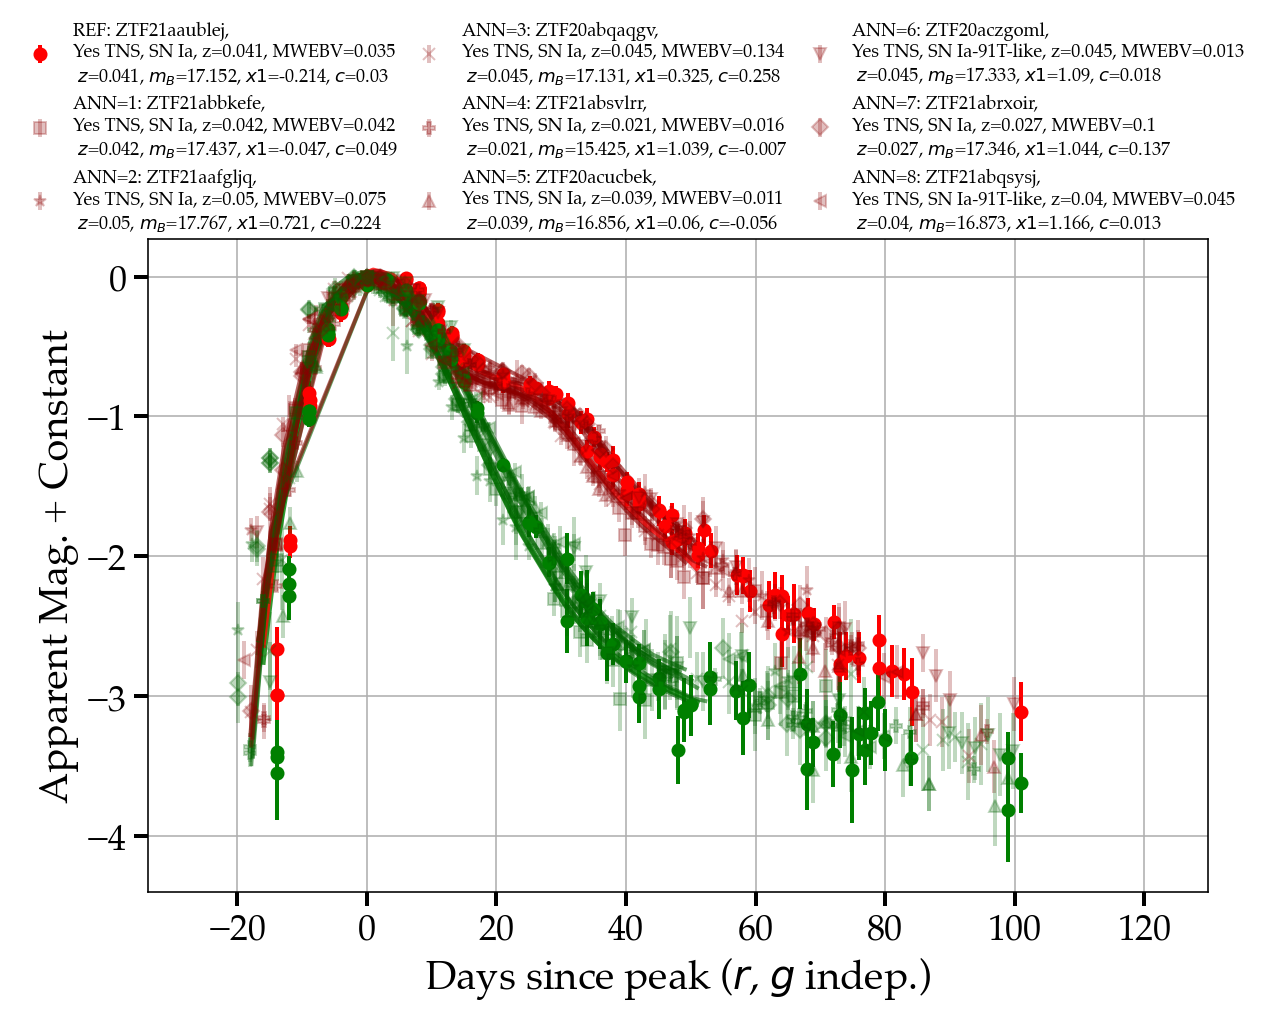

CPU times: user 8.16 s, sys: 837 ms, total: 8.99 s
Wall time: 6.33 s


In [20]:
%%time

ztf_id_ref = "ZTF21aaublej"
mwebv = 0.035
z= 0.041
mB_l = []

host_df_ztf_id_l, host_df_ra_l, host_df_dec_l = [], [], []

ref_info = antares_client.search.get_by_ztf_object_id(ztf_object_id=ztf_id_ref)

df_ref = ref_info.timeseries.to_pandas()

has_tns_ref = dataset_bank_tns_df.loc[ztf_id_ref].has_tns.replace('_', ' ')
tns_cls_ref = dataset_bank_tns_df.loc[ztf_id_ref].tns_cls
spec_z_ref = dataset_bank_tns_df.loc[ztf_id_ref].spec_z

fig, ax = plt.subplots(figsize=(9.5,6))
#plt.gca().invert_yaxis()

df_ref_g = df_ref[(df_ref.ant_passband == 'g') & (~df_ref.ant_mag.isna())]
df_ref_r = df_ref[(df_ref.ant_passband == 'R') & (~df_ref.ant_mag.isna())]

mjd_idx_at_min_mag_r_ref = df_ref_r[['ant_mag']].reset_index().idxmin().ant_mag
mjd_idx_at_min_mag_g_ref = df_ref_g[['ant_mag']].reset_index().idxmin().ant_mag


# apply SALT3 fit
time_arr_ref = df_ref[(~df_ref.ant_mag.isna())].ant_mjd.values
pb_arr_ref = df_ref[(~df_ref.ant_mag.isna())].ant_passband.values
mag_arr_ref = df_ref[(~df_ref.ant_mag.isna())].ant_mag.values
flux_arr_ref = 10**(-0.4 * (mag_arr_ref-27.5))
magerr_arr_ref = df_ref[(~df_ref.ant_mag.isna())].ant_magerr.values
fluxerr_arr_ref = (magerr_arr_ref*flux_arr_ref)/1.0857
lc_df_ref, param_dict_ref = return_salt3_fit_params_force_z(z=z, time_arr=time_arr_ref, pb_arr=pb_arr_ref, flux_arr=flux_arr_ref, fluxerr_arr=fluxerr_arr_ref)

ref_colors = ['g', 'r']
for i,f in enumerate(np.unique(lc_df_ref['band'])):
    if f == "ztfr": min_band_mag = df_ref_r.ant_mag.min()
    elif f == "ztfg": min_band_mag = df_ref_g.ant_mag.min()
    
    z= round(param_dict_ref['z'], 3)
    t0= round(param_dict_ref['t0'], 3)
    mB= round(param_dict_ref['mB'], 3)
    x1= round(param_dict_ref['x1'], 3)
    c= round(param_dict_ref['c'], 3)
    x0= round(param_dict_ref['x0'], 3)

    # careful about zpsys!
    model = sncosmo.Model(source='salt3')
    model.set(z=z,t0=param_dict_ref['t0'], x1=param_dict_ref['x1'],c=param_dict_ref['c'],x0=param_dict_ref['x0'])
    salt3flux = model.bandflux(f, lc_df_corrected_ref['time'], zp=27.5, zpsys='AB')
    salt3mag = 27.5 -2.5 * np.log10(salt3flux)
    ax.plot(lc_df_ref['time']-t0,min_band_mag-salt3mag,color=ref_colors[i], alpha=0.8, linewidth=3)

    #ax.text(0.45, 0.80, "Corrected"+'\n'+ fr"$z$={z}"+'\n'+ fr"$t_0$={t0}"+'\n'+ fr"$x1$={x1}"+'\n'+ fr"$c$={c}"+'\n'+ fr"$x_0$={x0}",#+'\n'+ fr"$m_{pkflt}$={pkmag}", 
    #        horizontalalignment='center', 
    #         verticalalignment='center', 
    #         transform=ax.transAxes,
    #         fontsize=14)
# UnCorrected
ax.errorbar(x=df_ref_r.ant_mjd-df_ref_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_ref], y=df_ref_r.ant_mag.min()-df_ref_r.ant_mag, yerr=df_ref_r.ant_magerr, fmt='o', c='r',
           label=f"REF: {ztf_id_ref}, \n{has_tns_ref},\t{tns_cls_ref},\tz={round(spec_z_ref, 3)}, MWEBV={mwebv}\n $z$={z}, $m_B$={mB}, $x1$={x1}, $c$={c}")
ax.errorbar(x=df_ref_g.ant_mjd-df_ref_g.ant_mjd.iloc[mjd_idx_at_min_mag_g_ref], y=df_ref_g.ant_mag.min()-df_ref_g.ant_mag, yerr=df_ref_g.ant_magerr, fmt='o', c='g')

mB_l.append(param_dict_ref['mB'])
print("#########")
    
    
markers = ['s', '*', 'x', 'P', '^', 'v', 'D', '<', '>', '8', 'p', 'x'] 
consts = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36] 

ztf_id_l = ["ZTF21abbkefe", "ZTF21aafgljq", "ZTF20abqaqgv", "ZTF21absvlrr", "ZTF20acucbek", "ZTF20aczgoml",
           "ZTF21abrxoir", "ZTF21abqsysj"]
z_l = [0.042, 0.05, 0.045, 0.021, 0.039, 0.045, 0.027, 0.04]
mwebv_l = [0.042, 0.075, 0.134, 0.016, 0.011, 0.013, 0.1, 0.045]
spec_cls_l = ["SN Ia", "SN Ia", "SN Ia", "SN Ia", "SN Ia", "SN Ia-91T-like", "SN Ia", "SN Ia-91T-like"]


knn_colors = ['darkgreen', 'darkred']
for num, (ztf_id_knn, z_knn, mwebv_knn, spec_cls_knn) in enumerate(zip(ztf_id_l, z_l, mwebv_l, spec_cls_l)):
    print(num, (ztf_id_knn, z_knn, mwebv_knn, spec_cls_knn))
    ztf_id_ann = ztf_id_knn

    try:
        l_info = antares_client.search.get_by_ztf_object_id(ztf_object_id=ztf_id_ann)
        df_knn = l_info.timeseries.to_pandas()
    except: continue  
    
    has_tns_knn = dataset_bank_tns_df.loc[ztf_id_ann].has_tns.replace('_', ' ')
    tns_cls_knn = dataset_bank_tns_df.loc[ztf_id_ann].tns_cls
    spec_z_knn = dataset_bank_tns_df.loc[ztf_id_ann].spec_z


    df_knn_g = df_knn[(df_knn.ant_passband == 'g') & (~df_knn.ant_mag.isna())]
    df_knn_r = df_knn[(df_knn.ant_passband == 'R') & (~df_knn.ant_mag.isna())]
    
    mjd_idx_at_min_mag_r_knn = df_knn_r[['ant_mag']].reset_index().idxmin().ant_mag
    mjd_idx_at_min_mag_g_knn = df_knn_g[['ant_mag']].reset_index().idxmin().ant_mag
    
    # apply SALT3 fit
    time_arr_knn = df_knn[(~df_knn.ant_mag.isna())].ant_mjd.values
    pb_arr_knn = df_knn[(~df_knn.ant_mag.isna())].ant_passband.values
    mag_arr_knn = df_knn[(~df_knn.ant_mag.isna())].ant_mag.values
    flux_arr_knn = 10**(-0.4 * (mag_arr_knn-27.5))
    magerr_arr_knn = df_knn[(~df_knn.ant_mag.isna())].ant_magerr.values
    fluxerr_arr_knn = (magerr_arr_knn*flux_arr_knn)/1.0857
    
    if spec_cls_knn.startswith("SN Ia"):
        try:
            lc_df_knn, param_dict_knn = return_salt3_fit_params_force_z(z=z_knn, time_arr=time_arr_knn, pb_arr=pb_arr_knn, flux_arr=flux_arr_knn, fluxerr_arr=fluxerr_arr_knn)
        except: 
            print("Bad SALT FIT with z=spec z. Trying again with z unbounded...")
            try:
                lc_df_knn, param_dict_knn = return_salt3_fit_params(z=z_knn, time_arr=time_arr_knn, pb_arr=pb_arr_knn, flux_arr=flux_arr_knn, fluxerr_arr=fluxerr_arr_knn)
            except:
                print("Bad fit again. Continue...")
                ax.errorbar(x=df_knn_r.ant_mjd-df_knn_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_knn], y=df_knn_r.ant_mag.min()-df_knn_r.ant_mag, yerr=df_knn_r.ant_magerr, fmt=markers[num], c='darkred', alpha=0.25, 
                   label=f"ANN={num+1}: {ztf_id_knn}, \n{has_tns_knn},\t{tns_cls_knn},\tz={round(spec_z_knn, 3)}, MWEBV={mwebv_knn}\n $z$=-99, $m_B$=-99, $x1$=-99, $c$=-99")
                ax.errorbar(x=df_knn_g.ant_mjd-df_knn_g.ant_mjd.iloc[mjd_idx_at_min_mag_g_knn], y=df_knn_g.ant_mag.min()-df_knn_g.ant_mag, yerr=df_knn_g.ant_magerr, fmt=markers[num], c='darkgreen', alpha=0.25)
                continue
        # Corrected
        #ax.errorbar(x=df_knn_r.ant_mjd-df_knn_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_knn], y=df_knn_r.ant_mag.min()-df_knn_r.ant_mag, yerr=df_knn_r.ant_magerr, fmt=markers[num], c='darkred', alpha=0.25, 
        #           label=f"ANN={num+1}: {ztf_id_knn}, \n{has_tns_knn},\t{tns_cls_knn},\tz={round(spec_z_knn, 3)}, MWEBV={mwebv_knn}\n $z$={z_knn}, $t_0$={t0}, $x1$={x1}, $c$={c}")
        #ax.errorbar(x=df_knn_g.ant_mjd-df_knn_g.ant_mjd.iloc[mjd_idx_at_min_mag_g_knn], y=df_knn_g.ant_mag.min()-df_knn_g.ant_mag, yerr=df_knn_g.ant_magerr, fmt=markers[num], c='darkgreen', alpha=0.25)
        
    else: 
        ax.errorbar(x=df_knn_r.ant_mjd-df_knn_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_knn], y=df_knn_r.ant_mag.min()-df_knn_r.ant_mag, yerr=df_knn_r.ant_magerr, fmt=markers[num], c='darkred', alpha=0.25, 
                   label=f"ANN={num+1}: {ztf_id_knn}, \n{has_tns_knn},\t{tns_cls_knn},\tz={round(spec_z_knn, 3)}, MWEBV={mwebv_knn}\n $z$=-99, $m_B$=-99, $x1$=-99, $c$=-99")
        ax.errorbar(x=df_knn_g.ant_mjd-df_knn_g.ant_mjd.iloc[mjd_idx_at_min_mag_g_knn], y=df_knn_g.ant_mag.min()-df_knn_g.ant_mag, yerr=df_knn_g.ant_magerr, fmt=markers[num], c='darkgreen', alpha=0.25)
    
    if spec_cls_knn.startswith("SN Ia"):
        for i,f in enumerate(np.unique(lc_df_knn['band'])):
            if f == "ztfr": min_band_mag = df_knn_r.ant_mag.min()
            elif f == "ztfg": min_band_mag = df_knn_g.ant_mag.min()

            z= round(param_dict_knn['z'], 3)
            t0= round(param_dict_knn['t0'], 3)
            mB= round(param_dict_knn['mB'], 3)
            x1= round(param_dict_knn['x1'], 3)
            c= round(param_dict_knn['c'], 3)
            x0= round(param_dict_knn['x0'], 3)
            
            # careful about zpsys!
            model = sncosmo.Model(source='salt3')
            model.set(z=z_knn,t0=param_dict_knn['t0'], x1=param_dict_knn['x1'],c=param_dict_knn['c'],x0=param_dict_knn['x0'])

            salt3flux = model.bandflux(f, lc_df_knn['time'], zp=27.5, zpsys='AB')
            salt3mag = 27.5 -2.5 * np.log10(salt3flux)
            ax.plot(lc_df_knn['time']-t0,min_band_mag-salt3mag,color=knn_colors[i], alpha=0.6, linewidth=2)
            
#         # Create a SALT3 model using sncosmo
#         parameters = {'x0': param_dict_knn['x0'], 'x1': param_dict_knn['x1'], 'c': param_dict_knn['c'], 't0': param_dict_knn['t0']}
#         print(parameters)
#         model = sncosmo.Model(source='salt3', effects=[sncosmo.CCM89Dust()], effect_names=['mw'], effect_frames=['obs'])
#         # Set the model parameters
#         model.set(**parameters)
#         # Calculate the apparent magnitude in the B-band at the time of maximum brightness (mB)
#         mB = model.bandmag('bessellb', 'ab', [0.0])
#         print("Peak B-band magnitude (mB):", mB)
            
        ax.errorbar(x=df_knn_r.ant_mjd-df_knn_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_knn], y=df_knn_r.ant_mag.min()-df_knn_r.ant_mag, yerr=df_knn_r.ant_magerr, fmt=markers[num], c='darkred', alpha=0.25, 
                   label=f"ANN={num+1}: {ztf_id_knn}, \n{has_tns_knn},\t{tns_cls_knn},\tz={round(spec_z_knn, 3)}, MWEBV={mwebv_knn}\n $z$={z_knn}, $m_B$={mB}, $x1$={x1}, $c$={c}")
        ax.errorbar(x=df_knn_g.ant_mjd-df_knn_g.ant_mjd.iloc[mjd_idx_at_min_mag_g_knn], y=df_knn_g.ant_mag.min()-df_knn_g.ant_mag, yerr=df_knn_g.ant_magerr, fmt=markers[num], c='darkgreen', alpha=0.25)
        
        mB_l.append(param_dict_knn['mB'])

    if df_ref_r.ant_mjd.iloc[0]-df_ref_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_ref] <= 10:
            plt.xlim((df_ref_r.ant_mjd.iloc[0]-df_ref_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_ref])-20, 
                     df_ref_r.ant_mjd.iloc[-1]-df_ref_r.ant_mjd.iloc[0]+15)
    else: 
        plt.xlim(2*(df_ref_r.ant_mjd.iloc[0]-df_ref_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_ref]), 
                 df_ref_r.ant_mjd.iloc[-1]-df_ref_r.ant_mjd.iloc[0]+15)
        
print("mB average (before correction) is:", np.mean(mB_l))
        
plt.ylabel('Apparent Mag. + Constant')
#plt.xlabel('Days of event') # make iloc[0]
plt.xlabel('Days since peak ($r$, $g$ indep.)') # (need r, g to be same)
# plt.legend(frameon=False,
#            bbox_to_anchor=(1.1,1.60),
#            ncol=2,
#            prop={'size': 10})
plt.legend(frameon=False,
           loc='upper right',
           bbox_to_anchor=(0.55, 0.86, 0.5, 0.5),
           ncol=3,
           columnspacing=0.75,
           prop={'size': 9.1})

#plt.gca().invert_yaxis()
plt.grid(True)

folder_path = f"../figures/salt3/"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

plt.savefig(f'../figures/salt3/{ztf_id_ref}_uncorrected_ANN0-8.pdf', dpi=300, bbox_inches='tight')
plt.show()

## ZTF21aapkhsc (2021fof), z=0.04, small smudgy elliptical 

{'z': 0.04, 't0': 59299.00671224242, 'x0': 0.002425759581341161, 'x1': -0.32097431170378576, 'c': 0.04874598290412147, 'mB': 17.17288061138477}
{'z': 0.04, 't0': 59299.11969946395, 'x0': 0.007210829095111987, 'x1': -0.24598733079135654, 'c': -0.5357906246607347, 'mB': 15.990036993981262}


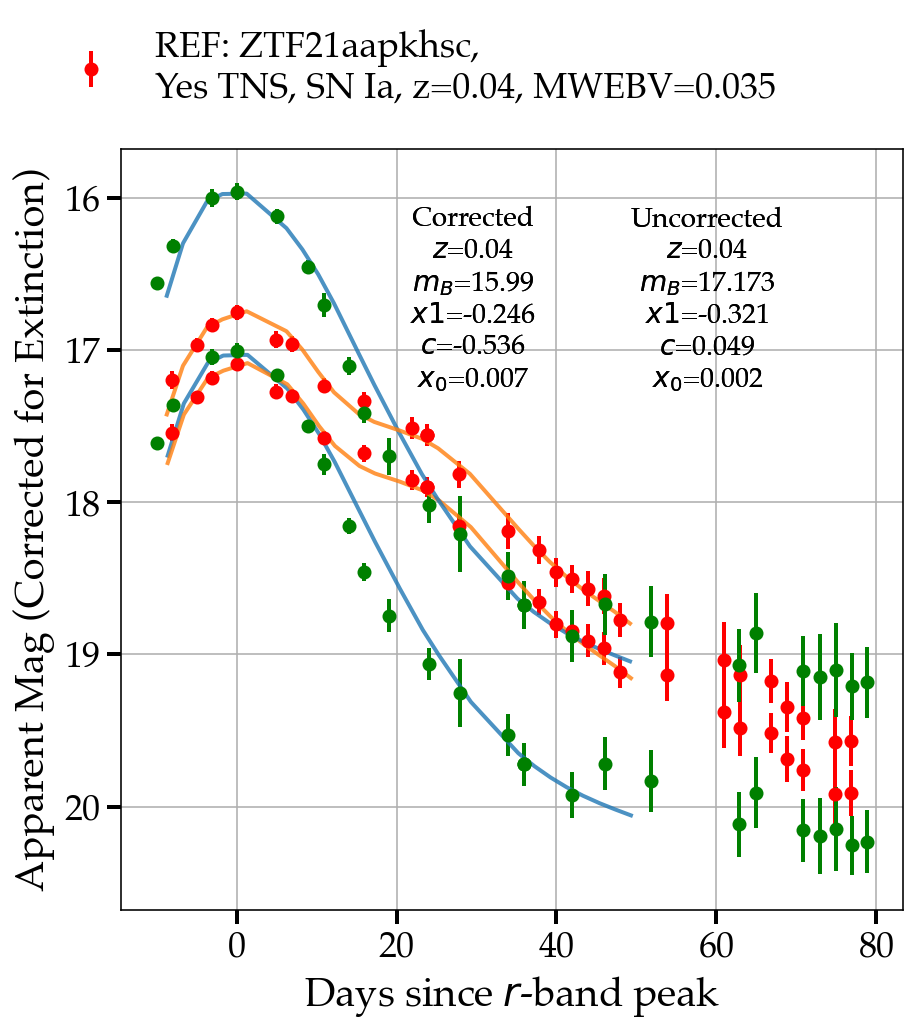

CPU times: user 2.14 s, sys: 170 ms, total: 2.31 s
Wall time: 1.95 s


In [12]:
%%time

ztf_id_ref = "ZTF21aapkhsc"
mwebv = 0.035
z= 0.04

host_df_ztf_id_l, host_df_ra_l, host_df_dec_l = [], [], []

#ztf_id_ref = ztf_id_ref #idx_arr[result_id[0]]
ref_info = antares_client.search.get_by_ztf_object_id(ztf_object_id=ztf_id_ref)

df_ref = ref_info.timeseries.to_pandas()

has_tns_ref = dataset_bank_tns_df.loc[ztf_id_ref].has_tns.replace('_', ' ')
tns_cls_ref = dataset_bank_tns_df.loc[ztf_id_ref].tns_cls
spec_z_ref = dataset_bank_tns_df.loc[ztf_id_ref].spec_z

# ra_ref = dataset_bank_orig_host_ra_dec.loc[ztf_id_ref].raMean
# dec_ref = dataset_bank_orig_host_ra_dec.loc[ztf_id_ref].decMean  

fig, ax = plt.subplots(figsize=(7,7))
#plt.gca().invert_yaxis()

df_ref_g = df_ref[(df_ref.ant_passband == 'g') & (~df_ref.ant_mag.isna())]
df_ref_r = df_ref[(df_ref.ant_passband == 'R') & (~df_ref.ant_mag.isna())]

mjd_idx_at_min_mag_r_ref = df_ref_r[['ant_mag']].reset_index().idxmin().ant_mag
mjd_idx_at_min_mag_g_ref = df_ref_g[['ant_mag']].reset_index().idxmin().ant_mag

# Uncorrected
ax.errorbar(x=df_ref_r.ant_mjd-df_ref_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_ref], y=df_ref_r.ant_mag, yerr=df_ref_r.ant_magerr, fmt='o', c='r')
ax.errorbar(x=df_ref_g.ant_mjd-df_ref_g.ant_mjd.iloc[mjd_idx_at_min_mag_r_ref], y=df_ref_g.ant_mag, yerr=df_ref_g.ant_magerr, fmt='o', c='g')

# apply SALT3 fit
time_arr_ref = df_ref[(~df_ref.ant_mag.isna())].ant_mjd.values
pb_arr_ref = df_ref[(~df_ref.ant_mag.isna())].ant_passband.values
mag_arr_ref = df_ref[(~df_ref.ant_mag.isna())].ant_mag.values
flux_arr_ref = 10**(-0.4 * (mag_arr_ref-27.5))
flux_corrected_arr_ref, mag_corrected_arr_ref, A_lambda_arr = get_extinction_corrected_mags(mwebv=mwebv, magnitudes=mag_arr_ref, pbs=pb_arr_ref)
magerr_arr_ref = df_ref[(~df_ref.ant_mag.isna())].ant_magerr.values
#fluxerr_corrected_arr_ref_notreal, magerr_corrected_arr_ref, A_lambda_arr = get_extinction_corrected_mags(mwebv=mwebv, magnitudes=magerr_arr_ref, pbs=pb_arr_ref)
fluxerr_arr_ref = (magerr_arr_ref*flux_arr_ref)/1.0857
fluxerr_corrected_arr_ref = (magerr_arr_ref*flux_corrected_arr_ref)/1.0857 #flux_arr_ref * 10**(0.4 * A_lambda_arr)
lc_df, param_dict = return_salt3_fit_params_force_z(z=z, time_arr=time_arr_ref, pb_arr=pb_arr_ref, flux_arr=flux_arr_ref, fluxerr_arr=fluxerr_arr_ref)
lc_df_corrected, param_dict_corrected = return_salt3_fit_params_force_z(z=z, time_arr=time_arr_ref, pb_arr=pb_arr_ref, flux_arr=flux_corrected_arr_ref, fluxerr_arr=fluxerr_corrected_arr_ref)


for i,f in enumerate(np.unique(lc_df['band'])):
    z= round(param_dict['z'], 3)
    t0= round(param_dict['t0'], 3)
    mB= round(param_dict['mB'], 3)
    x1= round(param_dict['x1'], 3)
    c= round(param_dict['c'], 3)
    x0= round(param_dict['x0'], 3)

    # careful about zpsys!
    model = sncosmo.Model(source='salt3')
    model.set(z=z,t0=param_dict['t0'], x1=param_dict['x1'],c=param_dict['c'],x0=param_dict['x0'])
    salt3flux = model.bandflux(f, lc_df['time'], zp=27.5, zpsys='AB')
    salt3mag = 27.5 -2.5 * np.log10(salt3flux)
    ax.plot(lc_df['time']-t0,salt3mag,color='C%i'%i, alpha=0.8, linewidth=2)

    ax.text(0.75, 0.80, "Uncorrected"+'\n'+ fr"$z$={z}"+'\n'+ fr"$m_B$={mB}"+'\n'+ fr"$x1$={x1}"+'\n'+ fr"$c$={c}"+'\n'+ fr"$x_0$={x0}",#+'\n'+ fr"$m_{pkflt}$={pkmag}", 
            horizontalalignment='center', 
             verticalalignment='center', 
             transform=ax.transAxes,
             fontsize=14)

# Corrected
corrected_mags_r = get_extinction_corrected_mags_pb(band_extinction_curve=calculate_band_mw_extinctions(['ztfr'])[0], 
                                                 mwebv=mwebv, magnitudes=df_ref_r.ant_mag.values)
corrected_mags_g = get_extinction_corrected_mags_pb(band_extinction_curve=calculate_band_mw_extinctions(['ztfg'])[0], 
                                                 mwebv=mwebv, magnitudes=df_ref_g.ant_mag.values)
corrected_magerrs_r = get_magerr_from_mag_pb(magnitude_errors=df_ref_r.ant_magerr, pbname='R')
corrected_magerrs_g = get_magerr_from_mag_pb(magnitude_errors=df_ref_g.ant_magerr, pbname='g')

ax.errorbar(x=df_ref_r.ant_mjd-df_ref_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_ref], y=corrected_mags_r, yerr=corrected_magerrs_r, fmt='o', c='r',
           label=f'REF: {ztf_id_ref}, \n{has_tns_ref},\t{tns_cls_ref},\tz={round(spec_z_ref, 3)}, MWEBV={mwebv}')
ax.errorbar(x=df_ref_g.ant_mjd-df_ref_g.ant_mjd.iloc[mjd_idx_at_min_mag_r_ref], y=corrected_mags_g, yerr=corrected_magerrs_g, fmt='o', c='g')

for i,f in enumerate(np.unique(lc_df['band'])):
    z= round(param_dict_corrected['z'], 3)
    t0= round(param_dict_corrected['t0'], 3)
    mB= round(param_dict_corrected['mB'], 3)
    x1= round(param_dict_corrected['x1'], 3)
    c= round(param_dict_corrected['c'], 3)
    x0= round(param_dict_corrected['x0'], 3)

    # careful about zpsys!
    model = sncosmo.Model(source='salt3')
    model.set(z=z,t0=param_dict_corrected['t0'], x1=param_dict_corrected['x1'],c=param_dict_corrected['c'],x0=param_dict_corrected['x0'])
    salt3flux = model.bandflux(f, lc_df['time'], zp=27.5, zpsys='AB')
    salt3mag = 27.5 -2.5 * np.log10(salt3flux)
    ax.plot(lc_df['time']-t0,salt3mag,color='C%i'%i, alpha=0.8, linewidth=2)

    ax.text(0.45, 0.80, "Corrected"+'\n'+ fr"$z$={z}"+'\n'+ fr"$m_B$={mB}"+'\n'+ fr"$x1$={x1}"+'\n'+ fr"$c$={c}"+'\n'+ fr"$x_0$={x0}",#+'\n'+ fr"$m_{pkflt}$={pkmag}", 
            horizontalalignment='center', 
             verticalalignment='center', 
             transform=ax.transAxes,
             fontsize=14)

plt.ylabel('Apparent Mag (Corrected for Extinction)')
plt.xlabel('Days since $r$-band peak')
plt.legend(frameon=False,
           bbox_to_anchor=(0.88,1.2),
           ncol=1,
           prop={'size': 18})

plt.gca().invert_yaxis()
plt.grid(True)

folder_path = f"../figures/salt3/"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

plt.savefig(f'../figures/salt3/{ztf_id_ref}_corrected_vs_uncorrected.jpg', dpi=300, bbox_inches='tight')
plt.show()

In [13]:
# SALT 3 for corrected

{'z': 0.06667886748201467, 't0': 59299.23190869609, 'x0': 0.006597361433173247, 'x1': -0.3446805439729163, 'c': -0.5511992598733902, 'mB': 16.086574306650117}
###########
0 ('ZTF20acifwef', 0.0364, 0.022, 'SN Ia')
{'z': 0.0364, 't0': 59146.69738751925, 'x0': 0.005735445412202709, 'x1': -0.3663407593059105, 'c': -0.3719453825856365, 'mB': 16.2385821233299}
1 ('ZTF20actoakx', 0.03, 0.023, 'SN Ia')
{'z': 0.03, 't0': 59192.88343999475, 'x0': 0.0058460626824461065, 'x1': 1.5867379192546323, 'c': -0.32857729947811454, 'mB': 16.217841330941788}
2 ('ZTF21aamfcji', 0.046105, 0.012, 'SN Ia')
{'z': 0.046105, 't0': 59281.04365402516, 'x0': 0.002201369055854071, 'x1': 0.2716393817054958, 'c': -0.07711780698566567, 'mB': 17.278267856491528}
3 ('ZTF21abcrhpk', 0.0744, 0.05, 'SN Ia')
{'z': 0.0744, 't0': 59374.966557874206, 'x0': 0.00355527636264538, 'x1': 1.5067232782947684, 'c': -0.7513052572477984, 'mB': 16.757816586416478}
4 ('ZTF21aagycrc', 0.068, 0.009, 'SN Ia')
{'z': 0.068, 't0': 59250.190521529

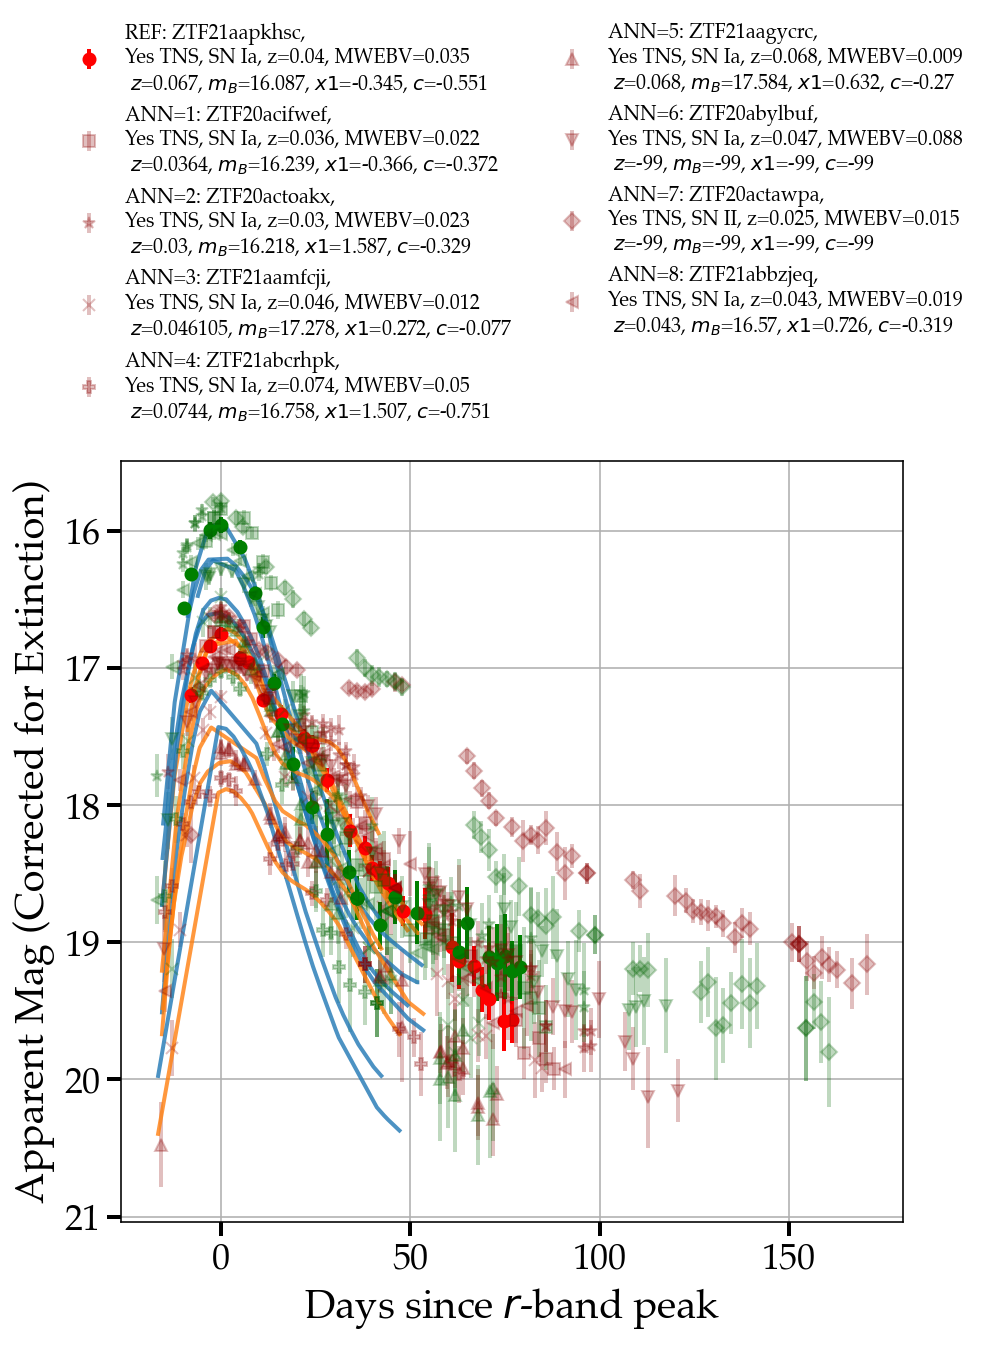

CPU times: user 6.67 s, sys: 642 ms, total: 7.31 s
Wall time: 6.37 s


In [14]:
%%time

ztf_id_ref = "ZTF21aapkhsc"
mwebv = 0.035
z= 0.04
mB_l = []

host_df_ztf_id_l, host_df_ra_l, host_df_dec_l = [], [], []

ref_info = antares_client.search.get_by_ztf_object_id(ztf_object_id=ztf_id_ref)

df_ref = ref_info.timeseries.to_pandas()

has_tns_ref = dataset_bank_tns_df.loc[ztf_id_ref].has_tns.replace('_', ' ')
tns_cls_ref = dataset_bank_tns_df.loc[ztf_id_ref].tns_cls
spec_z_ref = dataset_bank_tns_df.loc[ztf_id_ref].spec_z

fig, ax = plt.subplots(figsize=(7,7))
#plt.gca().invert_yaxis()

df_ref_g = df_ref[(df_ref.ant_passband == 'g') & (~df_ref.ant_mag.isna())]
df_ref_r = df_ref[(df_ref.ant_passband == 'R') & (~df_ref.ant_mag.isna())]

mjd_idx_at_min_mag_r_ref = df_ref_r[['ant_mag']].reset_index().idxmin().ant_mag
mjd_idx_at_min_mag_g_ref = df_ref_g[['ant_mag']].reset_index().idxmin().ant_mag


# apply SALT3 fit
time_arr_ref = df_ref[(~df_ref.ant_mag.isna())].ant_mjd.values
pb_arr_ref = df_ref[(~df_ref.ant_mag.isna())].ant_passband.values
mag_arr_ref = df_ref[(~df_ref.ant_mag.isna())].ant_mag.values
flux_arr_ref = 10**(-0.4 * (mag_arr_ref-27.5))
flux_corrected_arr_ref, mag_corrected_arr_ref, A_lambda_arr = get_extinction_corrected_mags(mwebv=mwebv, magnitudes=mag_arr_ref, pbs=pb_arr_ref)
magerr_arr_ref = df_ref[(~df_ref.ant_mag.isna())].ant_magerr.values
#fluxerr_corrected_arr_ref_notreal, magerr_corrected_arr_ref, A_lambda_arr = get_extinction_corrected_mags(mwebv=mwebv, magnitudes=magerr_arr_ref, pbs=pb_arr_ref)
fluxerr_arr_ref = (magerr_arr_ref*flux_arr_ref)/1.0857
fluxerr_corrected_arr_ref = (magerr_arr_ref*flux_corrected_arr_ref)/1.0857 #flux_arr_ref * 10**(0.4 * A_lambda_arr)
lc_df_corrected_ref, param_dict_corrected_ref = return_salt3_fit_params(z=z, time_arr=time_arr_ref, pb_arr=pb_arr_ref, flux_arr=flux_corrected_arr_ref, fluxerr_arr=fluxerr_corrected_arr_ref)

# Corrected
corrected_mags_r = get_extinction_corrected_mags_pb(band_extinction_curve=calculate_band_mw_extinctions(['ztfr'])[0], 
                                                 mwebv=mwebv, magnitudes=df_ref_r.ant_mag.values)
corrected_mags_g = get_extinction_corrected_mags_pb(band_extinction_curve=calculate_band_mw_extinctions(['ztfg'])[0], 
                                                 mwebv=mwebv, magnitudes=df_ref_g.ant_mag.values)
corrected_magerrs_r = get_magerr_from_mag_pb(magnitude_errors=df_ref_r.ant_magerr, pbname='R')
corrected_magerrs_g = get_magerr_from_mag_pb(magnitude_errors=df_ref_g.ant_magerr, pbname='g')

for i,f in enumerate(np.unique(lc_df_corrected_ref['band'])):
    z= round(param_dict_corrected_ref['z'], 3)
    t0= round(param_dict_corrected_ref['t0'], 3)
    mB= round(param_dict_corrected_ref['mB'], 3)
    x1= round(param_dict_corrected_ref['x1'], 3)
    c= round(param_dict_corrected_ref['c'], 3)
    x0= round(param_dict_corrected_ref['x0'], 3)

    # careful about zpsys!
    model = sncosmo.Model(source='salt3')
    model.set(z=z,t0=param_dict_corrected_ref['t0'], x1=param_dict_corrected_ref['x1'],c=param_dict_corrected_ref['c'],x0=param_dict_corrected_ref['x0'])
    salt3flux = model.bandflux(f, lc_df_corrected_ref['time'], zp=27.5, zpsys='AB')
    salt3mag = 27.5 -2.5 * np.log10(salt3flux)
    ax.plot(lc_df_corrected_ref['time']-t0,salt3mag,color='C%i'%i, alpha=0.8, linewidth=2)

    #ax.text(0.45, 0.80, "Corrected"+'\n'+ fr"$z$={z}"+'\n'+ fr"$t_0$={t0}"+'\n'+ fr"$x1$={x1}"+'\n'+ fr"$c$={c}"+'\n'+ fr"$x_0$={x0}",#+'\n'+ fr"$m_{pkflt}$={pkmag}", 
    #        horizontalalignment='center', 
    #         verticalalignment='center', 
    #         transform=ax.transAxes,
    #         fontsize=14)
    
ax.errorbar(x=df_ref_r.ant_mjd-df_ref_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_ref], y=corrected_mags_r, yerr=corrected_magerrs_r, fmt='o', c='r',
           label=f"REF: {ztf_id_ref}, \n{has_tns_ref},\t{tns_cls_ref},\tz={round(spec_z_ref, 3)}, MWEBV={mwebv}\n $z$={z}, $m_B$={mB}, $x1$={x1}, $c$={c}")
ax.errorbar(x=df_ref_g.ant_mjd-df_ref_g.ant_mjd.iloc[mjd_idx_at_min_mag_g_ref], y=corrected_mags_g, yerr=corrected_magerrs_g, fmt='o', c='g')

mB_l.append(param_dict_corrected_ref['mB'])
print("###########")
    
    
markers = ['s', '*', 'x', 'P', '^', 'v', 'D', '<', '>', '8', 'p', 'x'] 
consts = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36] 

ztf_id_l = ["ZTF20acifwef", "ZTF20actoakx", "ZTF21aamfcji", "ZTF21abcrhpk", "ZTF21aagycrc",
            "ZTF20abylbuf", "ZTF20actawpa", "ZTF21abbzjeq"]
z_l = [0.0364, 0.03, 0.046105, 0.0744, 0.068, 0.0468, 0.025, 0.043]
mwebv_l = [0.022, 0.023, 0.012, 0.05, 0.009, 0.088, 0.015, 0.019]
spec_cls_l = ["SN Ia", "SN Ia", "SN Ia", "SN Ia", "SN Ia", "SN Ia", "SN II", "SN Ia"]


for num, (ztf_id_knn, z_knn, mwebv_knn, spec_cls_knn) in enumerate(zip(ztf_id_l, z_l, mwebv_l, spec_cls_l)):
    print(num, (ztf_id_knn, z_knn, mwebv_knn, spec_cls_knn))
    ztf_id_ann = ztf_id_knn

    try:
        l_info = antares_client.search.get_by_ztf_object_id(ztf_object_id=ztf_id_ann)
        df_knn = l_info.timeseries.to_pandas()
    except: continue  
    
    has_tns_knn = dataset_bank_tns_df.loc[ztf_id_ann].has_tns.replace('_', ' ')
    tns_cls_knn = dataset_bank_tns_df.loc[ztf_id_ann].tns_cls
    spec_z_knn = dataset_bank_tns_df.loc[ztf_id_ann].spec_z


    df_knn_g = df_knn[(df_knn.ant_passband == 'g') & (~df_knn.ant_mag.isna())]
    df_knn_r = df_knn[(df_knn.ant_passband == 'R') & (~df_knn.ant_mag.isna())]
    
    mjd_idx_at_min_mag_r_knn = df_knn_r[['ant_mag']].reset_index().idxmin().ant_mag
    mjd_idx_at_min_mag_g_knn = df_knn_g[['ant_mag']].reset_index().idxmin().ant_mag
    
    # apply SALT3 fit
    time_arr_knn = df_knn[(~df_knn.ant_mag.isna())].ant_mjd.values
    pb_arr_knn = df_knn[(~df_knn.ant_mag.isna())].ant_passband.values
    mag_arr_knn = df_knn[(~df_knn.ant_mag.isna())].ant_mag.values
    flux_arr_knn = 10**(-0.4 * (mag_arr_knn-27.5))
    flux_corrected_arr_knn, mag_corrected_arr_knn, A_lambda_arr_knn = get_extinction_corrected_mags(mwebv=mwebv_knn, magnitudes=mag_arr_knn, pbs=pb_arr_knn)
    magerr_arr_knn = df_knn[(~df_knn.ant_mag.isna())].ant_magerr.values
    fluxerr_corrected_arr_knn_notreal, magerr_corrected_arr_knn, A_lambda_arr_knn = get_extinction_corrected_mags(mwebv=mwebv_knn, magnitudes=magerr_arr_knn, pbs=pb_arr_knn)
    fluxerr_arr_knn = (magerr_arr_knn*flux_arr_knn)/1.0857
    fluxerr_corrected_arr_knn = (magerr_arr_knn*flux_corrected_arr_knn)/1.0857 #flux_arr_ref * 10**(0.4 * A_lambda_arr)
    # Corrected
    corrected_mags_r_knn = get_extinction_corrected_mags_pb(band_extinction_curve=calculate_band_mw_extinctions(['ztfr'])[0], 
                                                     mwebv=mwebv, magnitudes=df_knn_r.ant_mag.values)
    corrected_mags_g_knn = get_extinction_corrected_mags_pb(band_extinction_curve=calculate_band_mw_extinctions(['ztfg'])[0], 
                                                     mwebv=mwebv, magnitudes=df_knn_g.ant_mag.values)
    corrected_magerrs_r_knn = get_magerr_from_mag_pb(magnitude_errors=df_knn_r.ant_magerr, pbname='R')
    corrected_magerrs_g_knn = get_magerr_from_mag_pb(magnitude_errors=df_knn_g.ant_magerr, pbname='g')
    
    if spec_cls_knn.startswith("SN Ia"):
        try:
            lc_df_corrected_knn, param_dict_corrected_knn = return_salt3_fit_params_force_z(z=z_knn, time_arr=time_arr_knn, pb_arr=pb_arr_knn, flux_arr=flux_corrected_arr_knn, fluxerr_arr=fluxerr_corrected_arr_knn)
        except: 
            print("Bad fit. Continue...")   
            ax.errorbar(x=df_knn_r.ant_mjd-df_knn_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_knn], y=corrected_mags_r_knn, yerr=corrected_magerrs_r_knn, fmt=markers[num], c='darkred', alpha=0.25, 
               label=f"ANN={num+1}: {ztf_id_knn}, \n{has_tns_knn},\t{tns_cls_knn},\tz={round(spec_z_knn, 3)}, MWEBV={mwebv_knn}\n $z$=-99, $m_B$=-99, $x1$=-99, $c$=-99")
            ax.errorbar(x=df_knn_g.ant_mjd-df_knn_g.ant_mjd.iloc[mjd_idx_at_min_mag_g_knn], y=corrected_mags_g_knn, yerr=corrected_magerrs_g_knn, fmt=markers[num], c='darkgreen', alpha=0.25)
            continue
    
    else:
        ax.errorbar(x=df_knn_r.ant_mjd-df_knn_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_knn], y=corrected_mags_r_knn, yerr=corrected_magerrs_r_knn, fmt=markers[num], c='darkred', alpha=0.25, 
                   label=f"ANN={num+1}: {ztf_id_knn}, \n{has_tns_knn},\t{tns_cls_knn},\tz={round(spec_z_knn, 3)}, MWEBV={mwebv_knn}\n $z$=-99, $m_B$=-99, $x1$=-99, $c$=-99")
        ax.errorbar(x=df_knn_g.ant_mjd-df_knn_g.ant_mjd.iloc[mjd_idx_at_min_mag_g_knn], y=corrected_mags_g_knn, yerr=corrected_magerrs_g_knn, fmt=markers[num], c='darkgreen', alpha=0.25)
    
    if spec_cls_knn.startswith("SN Ia"):
        for i,f in enumerate(np.unique(lc_df_corrected_knn['band'])):
            z= round(param_dict_corrected_knn['z'], 3)
            t0= round(param_dict_corrected_knn['t0'], 3)
            mB= round(param_dict_corrected_knn['mB'], 3)
            x1= round(param_dict_corrected_knn['x1'], 3)
            c= round(param_dict_corrected_knn['c'], 3)
            x0= round(param_dict_corrected_knn['x0'], 3)
            # careful about zpsys!
            model = sncosmo.Model(source='salt3')
            model.set(z=z_knn,t0=param_dict_corrected_knn['t0'], x1=param_dict_corrected_knn['x1'],c=param_dict_corrected_knn['c'],x0=param_dict_corrected_knn['x0'])

            salt3flux = model.bandflux(f, lc_df_corrected_knn['time'], zp=27.5, zpsys='AB')
            salt3mag = 27.5 -2.5 * np.log10(salt3flux)
            ax.plot(lc_df_corrected_knn['time']-t0,salt3mag,color='C%i'%i, alpha=0.8, linewidth=2)
            
        ax.errorbar(x=df_knn_r.ant_mjd-df_knn_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_knn], y=corrected_mags_r_knn, yerr=corrected_magerrs_r_knn, fmt=markers[num], c='darkred', alpha=0.25, 
                   label=f"ANN={num+1}: {ztf_id_knn}, \n{has_tns_knn},\t{tns_cls_knn},\tz={round(spec_z_knn, 3)}, MWEBV={mwebv_knn}\n $z$={z_knn}, $m_B$={mB}, $x1$={x1}, $c$={c}")
        ax.errorbar(x=df_knn_g.ant_mjd-df_knn_g.ant_mjd.iloc[mjd_idx_at_min_mag_g_knn], y=corrected_mags_g_knn, yerr=corrected_magerrs_g_knn, fmt=markers[num], c='darkgreen', alpha=0.25)

        mB_l.append(param_dict_corrected_knn['mB'])
        
print("mB average (after correction) is:", np.mean(mB_l))

plt.ylabel('Apparent Mag (Corrected for Extinction)')
plt.xlabel('Days since $r$-band peak')
plt.legend(frameon=False,
           bbox_to_anchor=(1.1,1.6),
           ncol=2,
           prop={'size': 10})

plt.gca().invert_yaxis()
plt.grid(True)

folder_path = f"../figures/salt3/"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

plt.savefig(f'../figures/salt3/{ztf_id_ref}_corrected_ANN0-8.jpg', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
%%time

ztf_id_ref = "ZTF21aaublej"
mwebv = 0.035
z= 0.041
mB_l = []

host_df_ztf_id_l, host_df_ra_l, host_df_dec_l = [], [], []

ref_info = antares_client.search.get_by_ztf_object_id(ztf_object_id=ztf_id_ref)

df_ref = ref_info.timeseries.to_pandas()

has_tns_ref = dataset_bank_tns_df.loc[ztf_id_ref].has_tns.replace('_', ' ')
tns_cls_ref = dataset_bank_tns_df.loc[ztf_id_ref].tns_cls
spec_z_ref = dataset_bank_tns_df.loc[ztf_id_ref].spec_z

fig, ax = plt.subplots(figsize=(7,7))
#plt.gca().invert_yaxis()

df_ref_g = df_ref[(df_ref.ant_passband == 'g') & (~df_ref.ant_mag.isna())]
df_ref_r = df_ref[(df_ref.ant_passband == 'R') & (~df_ref.ant_mag.isna())]

mjd_idx_at_min_mag_r_ref = df_ref_r[['ant_mag']].reset_index().idxmin().ant_mag
mjd_idx_at_min_mag_g_ref = df_ref_g[['ant_mag']].reset_index().idxmin().ant_mag


# apply SALT3 fit
time_arr_ref = df_ref[(~df_ref.ant_mag.isna())].ant_mjd.values
pb_arr_ref = df_ref[(~df_ref.ant_mag.isna())].ant_passband.values
mag_arr_ref = df_ref[(~df_ref.ant_mag.isna())].ant_mag.values
flux_arr_ref = 10**(-0.4 * (mag_arr_ref-27.5))
magerr_arr_ref = df_ref[(~df_ref.ant_mag.isna())].ant_magerr.values
fluxerr_arr_ref = (magerr_arr_ref*flux_arr_ref)/1.0857
lc_df_ref, param_dict_ref = return_salt3_fit_params_force_z(z=z, time_arr=time_arr_ref, pb_arr=pb_arr_ref, flux_arr=flux_arr_ref, fluxerr_arr=fluxerr_arr_ref)

ref_colors = ['g', 'r']
for i,f in enumerate(np.unique(lc_df_ref['band'])):
    if f == "ztfr": min_band_mag = df_ref_r.ant_mag.min()
    elif f == "ztfg": min_band_mag = df_ref_g.ant_mag.min()
    
    z= round(param_dict_ref['z'], 3)
    t0= round(param_dict_ref['t0'], 3)
    mB= round(param_dict_ref['mB'], 3)
    x1= round(param_dict_ref['x1'], 3)
    c= round(param_dict_ref['c'], 3)
    x0= round(param_dict_ref['x0'], 3)

    # careful about zpsys!
    model = sncosmo.Model(source='salt3')
    model.set(z=z,t0=param_dict_ref['t0'], x1=param_dict_ref['x1'],c=param_dict_ref['c'],x0=param_dict_ref['x0'])
    salt3flux = model.bandflux(f, lc_df_corrected_ref['time'], zp=27.5, zpsys='AB')
    salt3mag = 27.5 -2.5 * np.log10(salt3flux)
    ax.plot(lc_df_ref['time']-t0,min_band_mag-salt3mag,color=ref_colors[i], alpha=0.8, linewidth=3)

    #ax.text(0.45, 0.80, "Corrected"+'\n'+ fr"$z$={z}"+'\n'+ fr"$t_0$={t0}"+'\n'+ fr"$x1$={x1}"+'\n'+ fr"$c$={c}"+'\n'+ fr"$x_0$={x0}",#+'\n'+ fr"$m_{pkflt}$={pkmag}", 
    #        horizontalalignment='center', 
    #         verticalalignment='center', 
    #         transform=ax.transAxes,
    #         fontsize=14)
# UnCorrected
ax.errorbar(x=df_ref_r.ant_mjd-df_ref_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_ref], y=df_ref_r.ant_mag.min()-df_ref_r.ant_mag, yerr=df_ref_r.ant_magerr, fmt='o', c='r',
           label=f"REF: {ztf_id_ref}, \n{has_tns_ref},\t{tns_cls_ref},\tz={round(spec_z_ref, 3)}, MWEBV={mwebv}\n $z$={z}, $m_B$={mB}, $x1$={x1}, $c$={c}")
ax.errorbar(x=df_ref_g.ant_mjd-df_ref_g.ant_mjd.iloc[mjd_idx_at_min_mag_g_ref], y=df_ref_g.ant_mag.min()-df_ref_g.ant_mag, yerr=df_ref_g.ant_magerr, fmt='o', c='g')

mB_l.append(param_dict_ref['mB'])
print("#########")
    
    
markers = ['s', '*', 'x', 'P', '^', 'v', 'D', '<', '>', '8', 'p', 'x'] 
consts = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36] 

ztf_id_l = ["ZTF21abbkefe", "ZTF21aafgljq", "ZTF20abqaqgv", "ZTF21absvlrr", "ZTF20acucbek", "ZTF20aczgoml",
           "ZTF21abrxoir", "ZTF21abqsysj"]
z_l = [0.041542, 0.05, 0.045, 0.0208, 0.03889, 0.0453189984, 0.026657, 0.04]
mwebv_l = [0.042, 0.075, 0.134, 0.016, 0.011, 0.013, 0.1, 0.045]
spec_cls_l = ["SN Ia", "SN Ia", "SN Ia", "SN Ia", "SN Ia", "SN Ia-91T-like", "SN Ia", "SN Ia-91T-like"]


knn_colors = ['darkgreen', 'darkred']
for num, (ztf_id_knn, z_knn, mwebv_knn, spec_cls_knn) in enumerate(zip(ztf_id_l, z_l, mwebv_l, spec_cls_l)):
    print(num, (ztf_id_knn, z_knn, mwebv_knn, spec_cls_knn))
    ztf_id_ann = ztf_id_knn

    try:
        l_info = antares_client.search.get_by_ztf_object_id(ztf_object_id=ztf_id_ann)
        df_knn = l_info.timeseries.to_pandas()
    except: continue  
    
    has_tns_knn = dataset_bank_tns_df.loc[ztf_id_ann].has_tns.replace('_', ' ')
    tns_cls_knn = dataset_bank_tns_df.loc[ztf_id_ann].tns_cls
    spec_z_knn = dataset_bank_tns_df.loc[ztf_id_ann].spec_z


    df_knn_g = df_knn[(df_knn.ant_passband == 'g') & (~df_knn.ant_mag.isna())]
    df_knn_r = df_knn[(df_knn.ant_passband == 'R') & (~df_knn.ant_mag.isna())]
    
    mjd_idx_at_min_mag_r_knn = df_knn_r[['ant_mag']].reset_index().idxmin().ant_mag
    mjd_idx_at_min_mag_g_knn = df_knn_g[['ant_mag']].reset_index().idxmin().ant_mag
    
    # apply SALT3 fit
    time_arr_knn = df_knn[(~df_knn.ant_mag.isna())].ant_mjd.values
    pb_arr_knn = df_knn[(~df_knn.ant_mag.isna())].ant_passband.values
    mag_arr_knn = df_knn[(~df_knn.ant_mag.isna())].ant_mag.values
    flux_arr_knn = 10**(-0.4 * (mag_arr_knn-27.5))
    magerr_arr_knn = df_knn[(~df_knn.ant_mag.isna())].ant_magerr.values
    fluxerr_arr_knn = (magerr_arr_knn*flux_arr_knn)/1.0857
    
    if spec_cls_knn.startswith("SN Ia"):
        try:
            lc_df_knn, param_dict_knn = return_salt3_fit_params_force_z(z=z_knn, time_arr=time_arr_knn, pb_arr=pb_arr_knn, flux_arr=flux_arr_knn, fluxerr_arr=fluxerr_arr_knn)
        except: 
            print("Bad SALT FIT with z=spec z. Trying again with z unbounded...")
            try:
                lc_df_knn, param_dict_knn = return_salt3_fit_params(z=z_knn, time_arr=time_arr_knn, pb_arr=pb_arr_knn, flux_arr=flux_arr_knn, fluxerr_arr=fluxerr_arr_knn)
            except:
                print("Bad fit again. Continue...")
                ax.errorbar(x=df_knn_r.ant_mjd-df_knn_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_knn], y=df_knn_r.ant_mag.min()-df_knn_r.ant_mag, yerr=df_knn_r.ant_magerr, fmt=markers[num], c='darkred', alpha=0.25, 
                   label=f"ANN={num+1}: {ztf_id_knn}, \n{has_tns_knn},\t{tns_cls_knn},\tz={round(spec_z_knn, 3)}, MWEBV={mwebv_knn}\n $z$=-99, $m_B$=-99, $x1$=-99, $c$=-99")
                ax.errorbar(x=df_knn_g.ant_mjd-df_knn_g.ant_mjd.iloc[mjd_idx_at_min_mag_g_knn], y=df_knn_g.ant_mag.min()-df_knn_g.ant_mag, yerr=df_knn_g.ant_magerr, fmt=markers[num], c='darkgreen', alpha=0.25)
                continue
        # Corrected
        #ax.errorbar(x=df_knn_r.ant_mjd-df_knn_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_knn], y=df_knn_r.ant_mag.min()-df_knn_r.ant_mag, yerr=df_knn_r.ant_magerr, fmt=markers[num], c='darkred', alpha=0.25, 
        #           label=f"ANN={num+1}: {ztf_id_knn}, \n{has_tns_knn},\t{tns_cls_knn},\tz={round(spec_z_knn, 3)}, MWEBV={mwebv_knn}\n $z$={z_knn}, $t_0$={t0}, $x1$={x1}, $c$={c}")
        #ax.errorbar(x=df_knn_g.ant_mjd-df_knn_g.ant_mjd.iloc[mjd_idx_at_min_mag_g_knn], y=df_knn_g.ant_mag.min()-df_knn_g.ant_mag, yerr=df_knn_g.ant_magerr, fmt=markers[num], c='darkgreen', alpha=0.25)
        
    else: 
        ax.errorbar(x=df_knn_r.ant_mjd-df_knn_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_knn], y=df_knn_r.ant_mag.min()-df_knn_r.ant_mag, yerr=df_knn_r.ant_magerr, fmt=markers[num], c='darkred', alpha=0.25, 
                   label=f"ANN={num+1}: {ztf_id_knn}, \n{has_tns_knn},\t{tns_cls_knn},\tz={round(spec_z_knn, 3)}, MWEBV={mwebv_knn}\n $z$=-99, $m_B$=-99, $x1$=-99, $c$=-99")
        ax.errorbar(x=df_knn_g.ant_mjd-df_knn_g.ant_mjd.iloc[mjd_idx_at_min_mag_g_knn], y=df_knn_g.ant_mag.min()-df_knn_g.ant_mag, yerr=df_knn_g.ant_magerr, fmt=markers[num], c='darkgreen', alpha=0.25)
    
    if spec_cls_knn.startswith("SN Ia"):
        for i,f in enumerate(np.unique(lc_df_knn['band'])):
            if f == "ztfr": min_band_mag = df_knn_r.ant_mag.min()
            elif f == "ztfg": min_band_mag = df_knn_g.ant_mag.min()

            z= round(param_dict_knn['z'], 3)
            t0= round(param_dict_knn['t0'], 3)
            mB= round(param_dict_knn['mB'], 3)
            x1= round(param_dict_knn['x1'], 3)
            c= round(param_dict_knn['c'], 3)
            x0= round(param_dict_knn['x0'], 3)
            
            # careful about zpsys!
            model = sncosmo.Model(source='salt3')
            model.set(z=z_knn,t0=param_dict_knn['t0'], x1=param_dict_knn['x1'],c=param_dict_knn['c'],x0=param_dict_knn['x0'])

            salt3flux = model.bandflux(f, lc_df_knn['time'], zp=27.5, zpsys='AB')
            salt3mag = 27.5 -2.5 * np.log10(salt3flux)
            ax.plot(lc_df_knn['time']-t0,min_band_mag-salt3mag,color=knn_colors[i], alpha=0.6, linewidth=2)
            
#         # Create a SALT3 model using sncosmo
#         parameters = {'x0': param_dict_knn['x0'], 'x1': param_dict_knn['x1'], 'c': param_dict_knn['c'], 't0': param_dict_knn['t0']}
#         print(parameters)
#         model = sncosmo.Model(source='salt3', effects=[sncosmo.CCM89Dust()], effect_names=['mw'], effect_frames=['obs'])
#         # Set the model parameters
#         model.set(**parameters)
#         # Calculate the apparent magnitude in the B-band at the time of maximum brightness (mB)
#         mB = model.bandmag('bessellb', 'ab', [0.0])
#         print("Peak B-band magnitude (mB):", mB)
            
        ax.errorbar(x=df_knn_r.ant_mjd-df_knn_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_knn], y=df_knn_r.ant_mag.min()-df_knn_r.ant_mag, yerr=df_knn_r.ant_magerr, fmt=markers[num], c='darkred', alpha=0.25, 
                   label=f"ANN={num+1}: {ztf_id_knn}, \n{has_tns_knn},\t{tns_cls_knn},\tz={round(spec_z_knn, 3)}, MWEBV={mwebv_knn}\n $z$={z_knn}, $m_B$={mB}, $x1$={x1}, $c$={c}")
        ax.errorbar(x=df_knn_g.ant_mjd-df_knn_g.ant_mjd.iloc[mjd_idx_at_min_mag_g_knn], y=df_knn_g.ant_mag.min()-df_knn_g.ant_mag, yerr=df_knn_g.ant_magerr, fmt=markers[num], c='darkgreen', alpha=0.25)
        
        mB_l.append(param_dict_knn['mB'])

    if df_ref_r.ant_mjd.iloc[0]-df_ref_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_ref] <= 10:
            plt.xlim((df_ref_r.ant_mjd.iloc[0]-df_ref_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_ref])-20, 
                     df_ref_r.ant_mjd.iloc[-1]-df_ref_r.ant_mjd.iloc[0]+15)
    else: 
        plt.xlim(2*(df_ref_r.ant_mjd.iloc[0]-df_ref_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_ref]), 
                 df_ref_r.ant_mjd.iloc[-1]-df_ref_r.ant_mjd.iloc[0]+15)
        
print("mB average (before correction) is:", np.mean(mB_l))
        
plt.ylabel('Apparent Mag. + Constant')
#plt.xlabel('Days of event') # make iloc[0]
plt.xlabel('Days since peak ($r$, $g$ indep.)') # (need r, g to be same)
plt.legend(frameon=False,
           bbox_to_anchor=(1.1,1.60),
           ncol=2,
           prop={'size': 10})

#plt.gca().invert_yaxis()
plt.grid(True)

folder_path = f"../figures/salt3/"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

plt.savefig(f'../figures/salt3/{ztf_id_ref}_uncorrected_ANN0-8.jpg', dpi=300, bbox_inches='tight')
plt.show()

# Old

{'z': 0.04, 't0': 59299.00671224242, 'x0': 0.002425759581341161, 'x1': -0.32097431170378576, 'c': 0.04874598290412147, 'mB': 17.17288061138477}
#########
0 ('ZTF20acifwef', 0.0364, 0.022, 'SN Ia')
{'z': 0.0364, 't0': 59146.167652714736, 'x0': 0.002877707414315712, 'x1': -0.2588716854886155, 'c': -0.00698210875453269, 'mB': 16.98738341064731}
1 ('ZTF20actoakx', 0.03, 0.023, 'SN Ia')
{'z': 0.03, 't0': 59192.84255570767, 'x0': 0.002818888748854133, 'x1': 1.492957804686442, 'c': 0.058813147516322196, 'mB': 17.009805159480415}
2 ('ZTF21aamfcji', 0.046105, 0.012, 'SN Ia')
{'z': 0.046105, 't0': 59281.02742503893, 'x0': 0.001515484783592008, 'x1': 0.23888557711520303, 'c': 0.12436002830947657, 'mB': 17.683621049651656}
3 ('ZTF21abcrhpk', 0.0744, 0.05, 'SN Ia')
{'z': 0.0744, 't0': 59374.858805376156, 'x0': 0.0008746865666487909, 'x1': 1.3170570101690786, 'c': 0.03451487889640139, 'mB': 18.280368858189547}
4 ('ZTF21aagycrc', 0.068, 0.009, 'SN Ia')
{'z': 0.068, 't0': 59250.18892623938, 'x0': 0.00

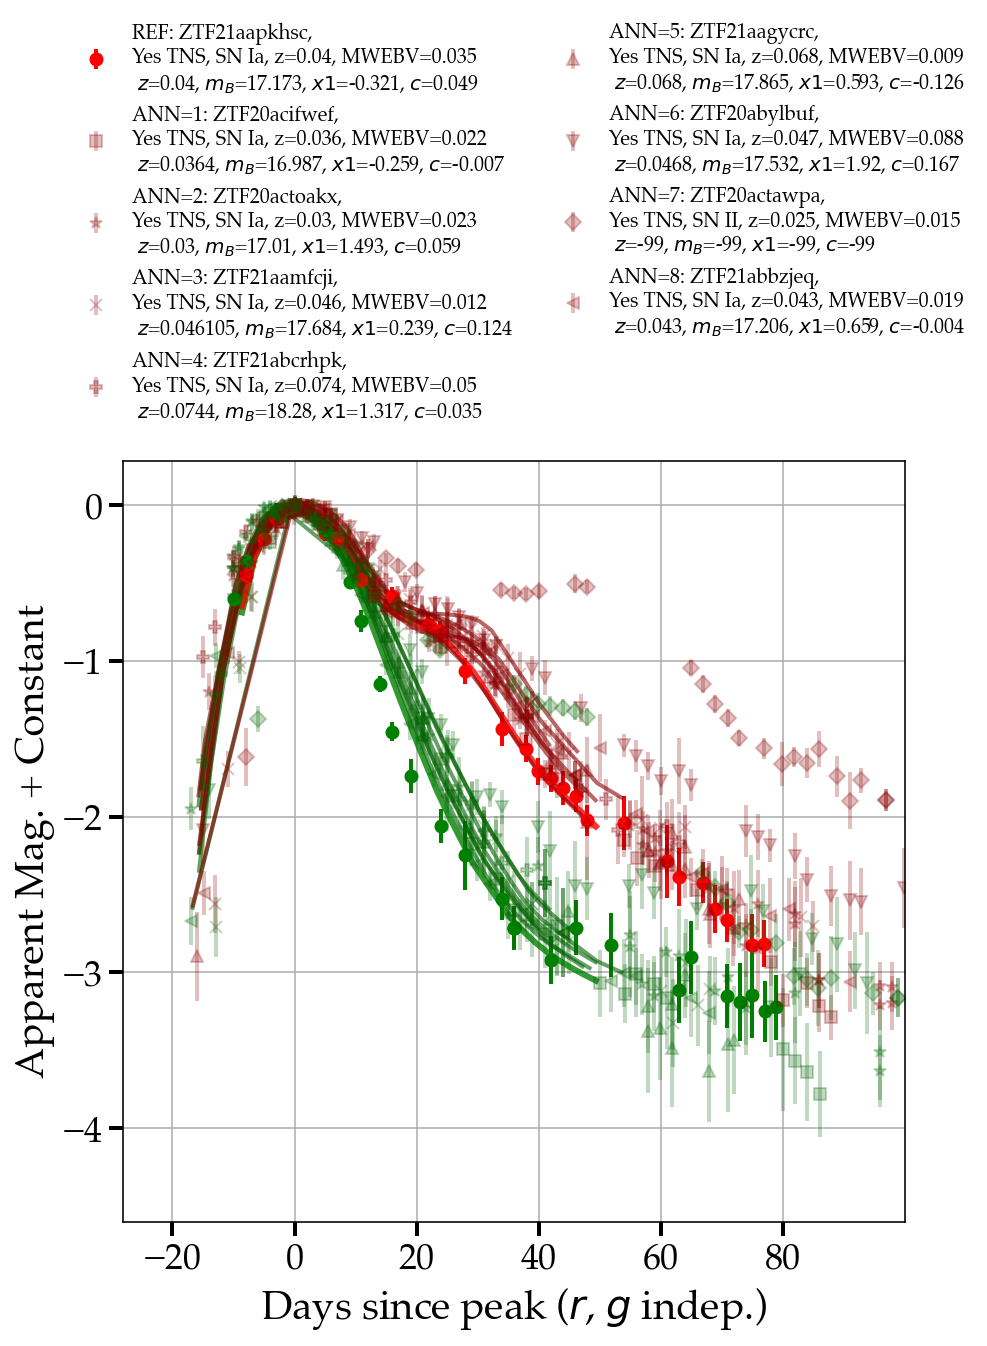

CPU times: user 6.13 s, sys: 633 ms, total: 6.76 s
Wall time: 5.69 s


In [15]:
%%time

ztf_id_ref = "ZTF21aapkhsc"
mwebv = 0.035
z= 0.04
mB_l = []

host_df_ztf_id_l, host_df_ra_l, host_df_dec_l = [], [], []

ref_info = antares_client.search.get_by_ztf_object_id(ztf_object_id=ztf_id_ref)

df_ref = ref_info.timeseries.to_pandas()

has_tns_ref = dataset_bank_tns_df.loc[ztf_id_ref].has_tns.replace('_', ' ')
tns_cls_ref = dataset_bank_tns_df.loc[ztf_id_ref].tns_cls
spec_z_ref = dataset_bank_tns_df.loc[ztf_id_ref].spec_z

fig, ax = plt.subplots(figsize=(7,7))
#plt.gca().invert_yaxis()

df_ref_g = df_ref[(df_ref.ant_passband == 'g') & (~df_ref.ant_mag.isna())]
df_ref_r = df_ref[(df_ref.ant_passband == 'R') & (~df_ref.ant_mag.isna())]

mjd_idx_at_min_mag_r_ref = df_ref_r[['ant_mag']].reset_index().idxmin().ant_mag
mjd_idx_at_min_mag_g_ref = df_ref_g[['ant_mag']].reset_index().idxmin().ant_mag


# apply SALT3 fit
time_arr_ref = df_ref[(~df_ref.ant_mag.isna())].ant_mjd.values
pb_arr_ref = df_ref[(~df_ref.ant_mag.isna())].ant_passband.values
mag_arr_ref = df_ref[(~df_ref.ant_mag.isna())].ant_mag.values
flux_arr_ref = 10**(-0.4 * (mag_arr_ref-27.5))
magerr_arr_ref = df_ref[(~df_ref.ant_mag.isna())].ant_magerr.values
fluxerr_arr_ref = (magerr_arr_ref*flux_arr_ref)/1.0857
lc_df_ref, param_dict_ref = return_salt3_fit_params_force_z(z=z, time_arr=time_arr_ref, pb_arr=pb_arr_ref, flux_arr=flux_arr_ref, fluxerr_arr=fluxerr_arr_ref)

ref_colors = ['g', 'r']
for i,f in enumerate(np.unique(lc_df_ref['band'])):
    if f == "ztfr": min_band_mag = df_ref_r.ant_mag.min()
    elif f == "ztfg": min_band_mag = df_ref_g.ant_mag.min()
    
    z= round(param_dict_ref['z'], 3)
    t0= round(param_dict_ref['t0'], 3)
    mB= round(param_dict_ref['mB'], 3)
    x1= round(param_dict_ref['x1'], 3)
    c= round(param_dict_ref['c'], 3)
    x0= round(param_dict_ref['x0'], 3)

    # careful about zpsys!
    model = sncosmo.Model(source='salt3')
    model.set(z=z,t0=param_dict_ref['t0'], x1=param_dict_ref['x1'],c=param_dict_ref['c'],x0=param_dict_ref['x0'])
    salt3flux = model.bandflux(f, lc_df_corrected_ref['time'], zp=27.5, zpsys='AB')
    salt3mag = 27.5 -2.5 * np.log10(salt3flux)
    ax.plot(lc_df_ref['time']-t0,min_band_mag-salt3mag,color=ref_colors[i], alpha=0.8, linewidth=3)

    #ax.text(0.45, 0.80, "Corrected"+'\n'+ fr"$z$={z}"+'\n'+ fr"$t_0$={t0}"+'\n'+ fr"$x1$={x1}"+'\n'+ fr"$c$={c}"+'\n'+ fr"$x_0$={x0}",#+'\n'+ fr"$m_{pkflt}$={pkmag}", 
    #        horizontalalignment='center', 
    #         verticalalignment='center', 
    #         transform=ax.transAxes,
    #         fontsize=14)
# UnCorrected
ax.errorbar(x=df_ref_r.ant_mjd-df_ref_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_ref], y=df_ref_r.ant_mag.min()-df_ref_r.ant_mag, yerr=df_ref_r.ant_magerr, fmt='o', c='r',
           label=f"REF: {ztf_id_ref}, \n{has_tns_ref},\t{tns_cls_ref},\tz={round(spec_z_ref, 3)}, MWEBV={mwebv}\n $z$={z}, $m_B$={mB}, $x1$={x1}, $c$={c}")
ax.errorbar(x=df_ref_g.ant_mjd-df_ref_g.ant_mjd.iloc[mjd_idx_at_min_mag_g_ref], y=df_ref_g.ant_mag.min()-df_ref_g.ant_mag, yerr=df_ref_g.ant_magerr, fmt='o', c='g')

mB_l.append(param_dict_ref['mB'])
print("#########")
    
    
markers = ['s', '*', 'x', 'P', '^', 'v', 'D', '<', '>', '8', 'p', 'x'] 
consts = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36] 

ztf_id_l = ["ZTF20acifwef", "ZTF20actoakx", "ZTF21aamfcji", "ZTF21abcrhpk", "ZTF21aagycrc",
            "ZTF20abylbuf", "ZTF20actawpa", "ZTF21abbzjeq"]
z_l = [0.0364, 0.03, 0.046105, 0.0744, 0.068, 0.0468, 0.025, 0.043]
mwebv_l = [0.022, 0.023, 0.012, 0.05, 0.009, 0.088, 0.015, 0.019]
spec_cls_l = ["SN Ia", "SN Ia", "SN Ia", "SN Ia", "SN Ia", "SN Ia", "SN II", "SN Ia"]


knn_colors = ['darkgreen', 'darkred']
for num, (ztf_id_knn, z_knn, mwebv_knn, spec_cls_knn) in enumerate(zip(ztf_id_l, z_l, mwebv_l, spec_cls_l)):
    print(num, (ztf_id_knn, z_knn, mwebv_knn, spec_cls_knn))
    ztf_id_ann = ztf_id_knn

    try:
        l_info = antares_client.search.get_by_ztf_object_id(ztf_object_id=ztf_id_ann)
        df_knn = l_info.timeseries.to_pandas()
    except: continue  
    
    has_tns_knn = dataset_bank_tns_df.loc[ztf_id_ann].has_tns.replace('_', ' ')
    tns_cls_knn = dataset_bank_tns_df.loc[ztf_id_ann].tns_cls
    spec_z_knn = dataset_bank_tns_df.loc[ztf_id_ann].spec_z


    df_knn_g = df_knn[(df_knn.ant_passband == 'g') & (~df_knn.ant_mag.isna())]
    df_knn_r = df_knn[(df_knn.ant_passband == 'R') & (~df_knn.ant_mag.isna())]
    
    mjd_idx_at_min_mag_r_knn = df_knn_r[['ant_mag']].reset_index().idxmin().ant_mag
    mjd_idx_at_min_mag_g_knn = df_knn_g[['ant_mag']].reset_index().idxmin().ant_mag
    
    # apply SALT3 fit
    time_arr_knn = df_knn[(~df_knn.ant_mag.isna())].ant_mjd.values
    pb_arr_knn = df_knn[(~df_knn.ant_mag.isna())].ant_passband.values
    mag_arr_knn = df_knn[(~df_knn.ant_mag.isna())].ant_mag.values
    flux_arr_knn = 10**(-0.4 * (mag_arr_knn-27.5))
    magerr_arr_knn = df_knn[(~df_knn.ant_mag.isna())].ant_magerr.values
    fluxerr_arr_knn = (magerr_arr_knn*flux_arr_knn)/1.0857
    
    if spec_cls_knn.startswith("SN Ia"):
        try:
            lc_df_knn, param_dict_knn = return_salt3_fit_params_force_z(z=z_knn, time_arr=time_arr_knn, pb_arr=pb_arr_knn, flux_arr=flux_arr_knn, fluxerr_arr=fluxerr_arr_knn)
        except: 
            print("Bad SALT FIT with z=spec z. Trying again with z unbounded...")
            try:
                lc_df_knn, param_dict_knn = return_salt3_fit_params(z=z_knn, time_arr=time_arr_knn, pb_arr=pb_arr_knn, flux_arr=flux_arr_knn, fluxerr_arr=fluxerr_arr_knn)
            except:
                print("Bad fit again. Continue...")
                ax.errorbar(x=df_knn_r.ant_mjd-df_knn_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_knn], y=df_knn_r.ant_mag.min()-df_knn_r.ant_mag, yerr=df_knn_r.ant_magerr, fmt=markers[num], c='darkred', alpha=0.25, 
                   label=f"ANN={num+1}: {ztf_id_knn}, \n{has_tns_knn},\t{tns_cls_knn},\tz={round(spec_z_knn, 3)}, MWEBV={mwebv_knn}\n $z$=-99, $m_B$=-99, $x1$=-99, $c$=-99")
                ax.errorbar(x=df_knn_g.ant_mjd-df_knn_g.ant_mjd.iloc[mjd_idx_at_min_mag_g_knn], y=df_knn_g.ant_mag.min()-df_knn_g.ant_mag, yerr=df_knn_g.ant_magerr, fmt=markers[num], c='darkgreen', alpha=0.25)
                continue
        # Corrected
        #ax.errorbar(x=df_knn_r.ant_mjd-df_knn_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_knn], y=df_knn_r.ant_mag.min()-df_knn_r.ant_mag, yerr=df_knn_r.ant_magerr, fmt=markers[num], c='darkred', alpha=0.25, 
        #           label=f"ANN={num+1}: {ztf_id_knn}, \n{has_tns_knn},\t{tns_cls_knn},\tz={round(spec_z_knn, 3)}, MWEBV={mwebv_knn}\n $z$={z_knn}, $t_0$={t0}, $x1$={x1}, $c$={c}")
        #ax.errorbar(x=df_knn_g.ant_mjd-df_knn_g.ant_mjd.iloc[mjd_idx_at_min_mag_g_knn], y=df_knn_g.ant_mag.min()-df_knn_g.ant_mag, yerr=df_knn_g.ant_magerr, fmt=markers[num], c='darkgreen', alpha=0.25)
        
    else: 
        ax.errorbar(x=df_knn_r.ant_mjd-df_knn_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_knn], y=df_knn_r.ant_mag.min()-df_knn_r.ant_mag, yerr=df_knn_r.ant_magerr, fmt=markers[num], c='darkred', alpha=0.25, 
                   label=f"ANN={num+1}: {ztf_id_knn}, \n{has_tns_knn},\t{tns_cls_knn},\tz={round(spec_z_knn, 3)}, MWEBV={mwebv_knn}\n $z$=-99, $m_B$=-99, $x1$=-99, $c$=-99")
        ax.errorbar(x=df_knn_g.ant_mjd-df_knn_g.ant_mjd.iloc[mjd_idx_at_min_mag_g_knn], y=df_knn_g.ant_mag.min()-df_knn_g.ant_mag, yerr=df_knn_g.ant_magerr, fmt=markers[num], c='darkgreen', alpha=0.25)
    
    if spec_cls_knn.startswith("SN Ia"):
        for i,f in enumerate(np.unique(lc_df_knn['band'])):
            if f == "ztfr": min_band_mag = df_knn_r.ant_mag.min()
            elif f == "ztfg": min_band_mag = df_knn_g.ant_mag.min()

            z= round(param_dict_knn['z'], 3)
            t0= round(param_dict_knn['t0'], 3)
            mB= round(param_dict_knn['mB'], 3)
            x1= round(param_dict_knn['x1'], 3)
            c= round(param_dict_knn['c'], 3)
            x0= round(param_dict_knn['x0'], 3)
            
            # careful about zpsys!
            model = sncosmo.Model(source='salt3')
            model.set(z=z_knn,t0=param_dict_knn['t0'], x1=param_dict_knn['x1'],c=param_dict_knn['c'],x0=param_dict_knn['x0'])

            salt3flux = model.bandflux(f, lc_df_knn['time'], zp=27.5, zpsys='AB')
            salt3mag = 27.5 -2.5 * np.log10(salt3flux)
            ax.plot(lc_df_knn['time']-t0,min_band_mag-salt3mag,color=knn_colors[i], alpha=0.6, linewidth=2)
            
#         # Create a SALT3 model using sncosmo
#         parameters = {'x0': param_dict_knn['x0'], 'x1': param_dict_knn['x1'], 'c': param_dict_knn['c'], 't0': param_dict_knn['t0']}
#         print(parameters)
#         model = sncosmo.Model(source='salt3', effects=[sncosmo.CCM89Dust()], effect_names=['mw'], effect_frames=['obs'])
#         # Set the model parameters
#         model.set(**parameters)
#         # Calculate the apparent magnitude in the B-band at the time of maximum brightness (mB)
#         mB = model.bandmag('bessellb', 'ab', [0.0])
#         print("Peak B-band magnitude (mB):", mB)
            
        ax.errorbar(x=df_knn_r.ant_mjd-df_knn_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_knn], y=df_knn_r.ant_mag.min()-df_knn_r.ant_mag, yerr=df_knn_r.ant_magerr, fmt=markers[num], c='darkred', alpha=0.25, 
                   label=f"ANN={num+1}: {ztf_id_knn}, \n{has_tns_knn},\t{tns_cls_knn},\tz={round(spec_z_knn, 3)}, MWEBV={mwebv_knn}\n $z$={z_knn}, $m_B$={mB}, $x1$={x1}, $c$={c}")
        ax.errorbar(x=df_knn_g.ant_mjd-df_knn_g.ant_mjd.iloc[mjd_idx_at_min_mag_g_knn], y=df_knn_g.ant_mag.min()-df_knn_g.ant_mag, yerr=df_knn_g.ant_magerr, fmt=markers[num], c='darkgreen', alpha=0.25)
        
        mB_l.append(param_dict_knn['mB'])

    if df_ref_r.ant_mjd.iloc[0]-df_ref_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_ref] <= 10:
            plt.xlim((df_ref_r.ant_mjd.iloc[0]-df_ref_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_ref])-20, 
                     df_ref_r.ant_mjd.iloc[-1]-df_ref_r.ant_mjd.iloc[0]+15)
    else: 
        plt.xlim(2*(df_ref_r.ant_mjd.iloc[0]-df_ref_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_ref]), 
                 df_ref_r.ant_mjd.iloc[-1]-df_ref_r.ant_mjd.iloc[0]+15)
        
print("mB average (before correction) is:", np.mean(mB_l))
        
plt.ylabel('Apparent Mag. + Constant')
#plt.xlabel('Days of event') # make iloc[0]
plt.xlabel('Days since peak ($r$, $g$ indep.)') # (need r, g to be same)
plt.legend(frameon=False,
           bbox_to_anchor=(1.1,1.60),
           ncol=2,
           prop={'size': 10})

#plt.gca().invert_yaxis()
plt.grid(True)

folder_path = f"../figures/salt3/"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

plt.savefig(f'../figures/salt3/{ztf_id_ref}_uncorrected_ANN0-8.jpg', dpi=300, bbox_inches='tight')
plt.show()

# Mass step test
### ZTF21aaublej (medium-large spiral), z=0.041 vs one above


## ZTF21aaublej (2021ixf), z=0.041, medium large elliptical

{'z': 0.041, 't0': 59330.48913404568, 'x0': 0.0024732202829143312, 'x1': -0.21404214661362636, 'c': 0.030128404693020187, 'mB': 17.151843001258506}
{'z': 0.041, 't0': 59330.56736112155, 'x0': 0.007278108220140617, 'x1': -0.11346896832787179, 'c': -0.5507092041774219, 'mB': 15.979953727651981}


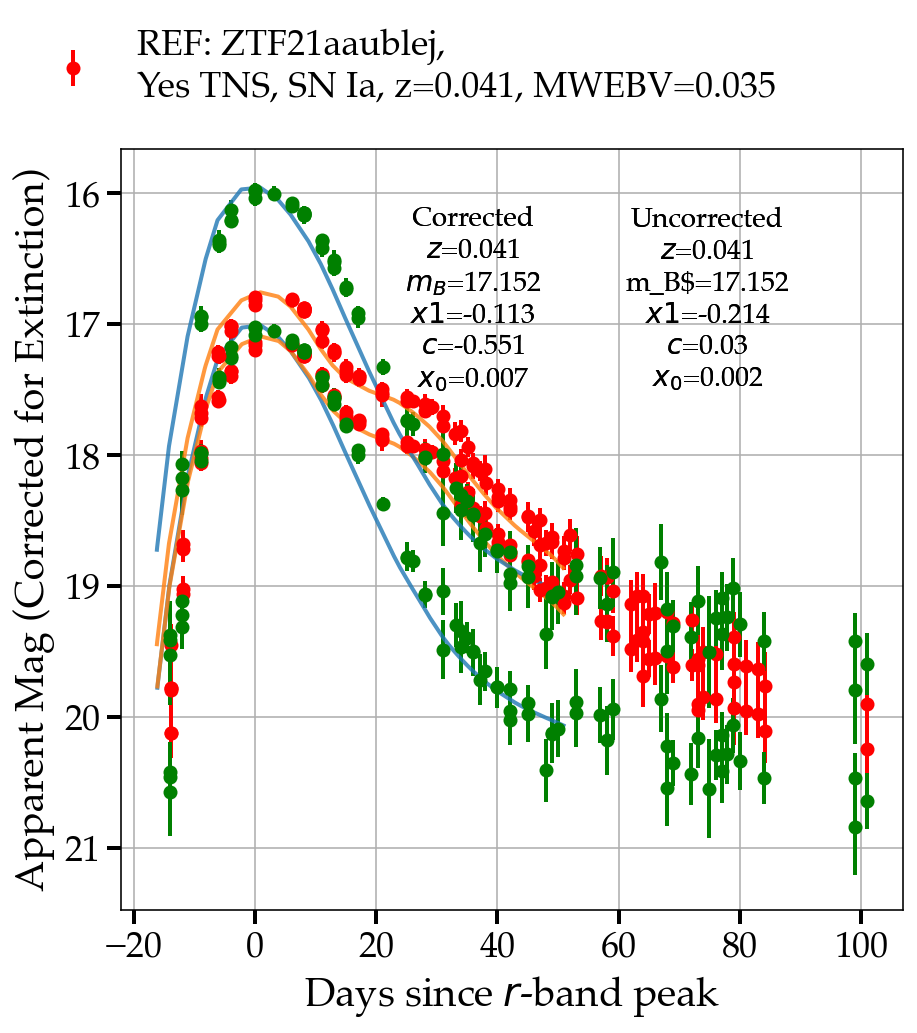

CPU times: user 2.45 s, sys: 276 ms, total: 2.73 s
Wall time: 1.61 s


In [16]:
%%time

ztf_id_ref = "ZTF21aaublej"
mwebv = 0.035
z= 0.041

host_df_ztf_id_l, host_df_ra_l, host_df_dec_l = [], [], []

#ztf_id_ref = ztf_id_ref #idx_arr[result_id[0]]
ref_info = antares_client.search.get_by_ztf_object_id(ztf_object_id=ztf_id_ref)

df_ref = ref_info.timeseries.to_pandas()

has_tns_ref = dataset_bank_tns_df.loc[ztf_id_ref].has_tns.replace('_', ' ')
tns_cls_ref = dataset_bank_tns_df.loc[ztf_id_ref].tns_cls
spec_z_ref = dataset_bank_tns_df.loc[ztf_id_ref].spec_z

# ra_ref = dataset_bank_orig_host_ra_dec.loc[ztf_id_ref].raMean
# dec_ref = dataset_bank_orig_host_ra_dec.loc[ztf_id_ref].decMean  

fig, ax = plt.subplots(figsize=(7,7))
#plt.gca().invert_yaxis()

df_ref_g = df_ref[(df_ref.ant_passband == 'g') & (~df_ref.ant_mag.isna())]
df_ref_r = df_ref[(df_ref.ant_passband == 'R') & (~df_ref.ant_mag.isna())]

mjd_idx_at_min_mag_r_ref = df_ref_r[['ant_mag']].reset_index().idxmin().ant_mag
mjd_idx_at_min_mag_g_ref = df_ref_g[['ant_mag']].reset_index().idxmin().ant_mag

# Uncorrected
ax.errorbar(x=df_ref_r.ant_mjd-df_ref_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_ref], y=df_ref_r.ant_mag, yerr=df_ref_r.ant_magerr, fmt='o', c='r')
ax.errorbar(x=df_ref_g.ant_mjd-df_ref_g.ant_mjd.iloc[mjd_idx_at_min_mag_r_ref], y=df_ref_g.ant_mag, yerr=df_ref_g.ant_magerr, fmt='o', c='g')

# apply SALT3 fit
time_arr_ref = df_ref[(~df_ref.ant_mag.isna())].ant_mjd.values
pb_arr_ref = df_ref[(~df_ref.ant_mag.isna())].ant_passband.values
mag_arr_ref = df_ref[(~df_ref.ant_mag.isna())].ant_mag.values
flux_arr_ref = 10**(-0.4 * (mag_arr_ref-27.5))
flux_corrected_arr_ref, mag_corrected_arr_ref, A_lambda_arr = get_extinction_corrected_mags(mwebv=mwebv, magnitudes=mag_arr_ref, pbs=pb_arr_ref)
magerr_arr_ref = df_ref[(~df_ref.ant_mag.isna())].ant_magerr.values
#fluxerr_corrected_arr_ref_notreal, magerr_corrected_arr_ref, A_lambda_arr = get_extinction_corrected_mags(mwebv=mwebv, magnitudes=magerr_arr_ref, pbs=pb_arr_ref)
fluxerr_arr_ref = (magerr_arr_ref*flux_arr_ref)/1.0857
fluxerr_corrected_arr_ref = (magerr_arr_ref*flux_corrected_arr_ref)/1.0857 #flux_arr_ref * 10**(0.4 * A_lambda_arr)
lc_df, param_dict = return_salt3_fit_params_force_z(z=z, time_arr=time_arr_ref, pb_arr=pb_arr_ref, flux_arr=flux_arr_ref, fluxerr_arr=fluxerr_arr_ref)
lc_df_corrected, param_dict_corrected = return_salt3_fit_params_force_z(z=z, time_arr=time_arr_ref, pb_arr=pb_arr_ref, flux_arr=flux_corrected_arr_ref, fluxerr_arr=fluxerr_corrected_arr_ref)


for i,f in enumerate(np.unique(lc_df['band'])):
    z= round(param_dict['z'], 3)
    t0= round(param_dict['t0'], 3)
    mB= round(param_dict['mB'], 3)
    x1= round(param_dict['x1'], 3)
    c= round(param_dict['c'], 3)
    x0= round(param_dict['x0'], 3)

    # careful about zpsys!
    model = sncosmo.Model(source='salt3')
    model.set(z=z,t0=param_dict['t0'], x1=param_dict['x1'],c=param_dict['c'],x0=param_dict['x0'])
    salt3flux = model.bandflux(f, lc_df['time'], zp=27.5, zpsys='AB')
    salt3mag = 27.5 -2.5 * np.log10(salt3flux)
    ax.plot(lc_df['time']-t0,salt3mag,color='C%i'%i, alpha=0.8, linewidth=2)

    ax.text(0.75, 0.80, "Uncorrected"+'\n'+ fr"$z$={z}"+'\n'+ fr"m_B$={mB}"+'\n'+ fr"$x1$={x1}"+'\n'+ fr"$c$={c}"+'\n'+ fr"$x_0$={x0}",#+'\n'+ fr"$m_{pkflt}$={pkmag}", 
            horizontalalignment='center', 
             verticalalignment='center', 
             transform=ax.transAxes,
             fontsize=14)

# Corrected
corrected_mags_r = get_extinction_corrected_mags_pb(band_extinction_curve=calculate_band_mw_extinctions(['ztfr'])[0], 
                                                 mwebv=mwebv, magnitudes=df_ref_r.ant_mag.values)
corrected_mags_g = get_extinction_corrected_mags_pb(band_extinction_curve=calculate_band_mw_extinctions(['ztfg'])[0], 
                                                 mwebv=mwebv, magnitudes=df_ref_g.ant_mag.values)
corrected_magerrs_r = get_magerr_from_mag_pb(magnitude_errors=df_ref_r.ant_magerr, pbname='R')
corrected_magerrs_g = get_magerr_from_mag_pb(magnitude_errors=df_ref_g.ant_magerr, pbname='g')

ax.errorbar(x=df_ref_r.ant_mjd-df_ref_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_ref], y=corrected_mags_r, yerr=corrected_magerrs_r, fmt='o', c='r',
           label=f'REF: {ztf_id_ref}, \n{has_tns_ref},\t{tns_cls_ref},\tz={round(spec_z_ref, 3)}, MWEBV={mwebv}')
ax.errorbar(x=df_ref_g.ant_mjd-df_ref_g.ant_mjd.iloc[mjd_idx_at_min_mag_r_ref], y=corrected_mags_g, yerr=corrected_magerrs_g, fmt='o', c='g')

for i,f in enumerate(np.unique(lc_df['band'])):
    z= round(param_dict_corrected['z'], 3)
    t0= round(param_dict_corrected['t0'], 3)
    x1= round(param_dict_corrected['x1'], 3)
    c= round(param_dict_corrected['c'], 3)
    x0= round(param_dict_corrected['x0'], 3)

    # careful about zpsys!
    model = sncosmo.Model(source='salt3')
    model.set(z=z,t0=param_dict_corrected['t0'], x1=param_dict_corrected['x1'],c=param_dict_corrected['c'],x0=param_dict_corrected['x0'])
    salt3flux = model.bandflux(f, lc_df['time'], zp=27.5, zpsys='AB')
    salt3mag = 27.5 -2.5 * np.log10(salt3flux)
    ax.plot(lc_df['time']-t0,salt3mag,color='C%i'%i, alpha=0.8, linewidth=2)

    ax.text(0.45, 0.80, "Corrected"+'\n'+ fr"$z$={z}"+'\n'+ fr"$m_B$={mB}"+'\n'+ fr"$x1$={x1}"+'\n'+ fr"$c$={c}"+'\n'+ fr"$x_0$={x0}",#+'\n'+ fr"$m_{pkflt}$={pkmag}", 
            horizontalalignment='center', 
             verticalalignment='center', 
             transform=ax.transAxes,
             fontsize=14)

plt.ylabel('Apparent Mag (Corrected for Extinction)')
plt.xlabel('Days since $r$-band peak')
plt.legend(frameon=False,
           bbox_to_anchor=(0.88,1.2),
           ncol=1,
           prop={'size': 18})

plt.gca().invert_yaxis()
plt.grid(True)

folder_path = f"../figures/salt3/"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

plt.savefig(f'../figures/salt3/{ztf_id_ref}_corrected_vs_uncorrected.jpg', dpi=300, bbox_inches='tight')
plt.show()

{'z': 0.03232401218709555, 't0': 59330.5016345637, 'x0': 0.007469820076528346, 'x1': -0.0683170975693718, 'c': -0.5399189693460049, 'mB': 15.951724646971531}
###########
0 ('ZTF21abbkefe', 0.041542, 0.042, 'SN Ia')
{'z': 0.041542, 't0': 59363.13832122659, 'x0': 0.006885559287744721, 'x1': 0.09654908763172489, 'c': -0.6422141160690187, 'mB': 16.04015194472087}
1 ('ZTF20abqaqgv', 0.045, 0.134, 'SN Ia')
{'z': 0.045, 't0': 59079.123138041134, 'x0': 0.12947189394667977, 'x1': 0.6719161863860329, 'c': -1.8839390828393439, 'mB': 12.854561247463682}
2 ('ZTF20acucbek', 0.03889, 0.011, 'SN Ia')
{'z': 0.03889, 't0': 59194.81157845504, 'x0': 0.004574902752627877, 'x1': 0.09814631068922057, 'c': -0.23966102876343898, 'mB': 16.484045332926055}
3 ('ZTF20aczgoml', 0.0453189984, 0.013, 'SN Ia-91T-like')
{'z': 0.0453189984, 't0': 59221.20520769396, 'x0': 0.0030918440432147784, 'x1': 0.9197247116424425, 'c': -0.19040882551220756, 'mB': 16.909456051502193}
4 ('ZTF21aaabaey', 0.06569, 0.035, 'SN Ia')
{'z':

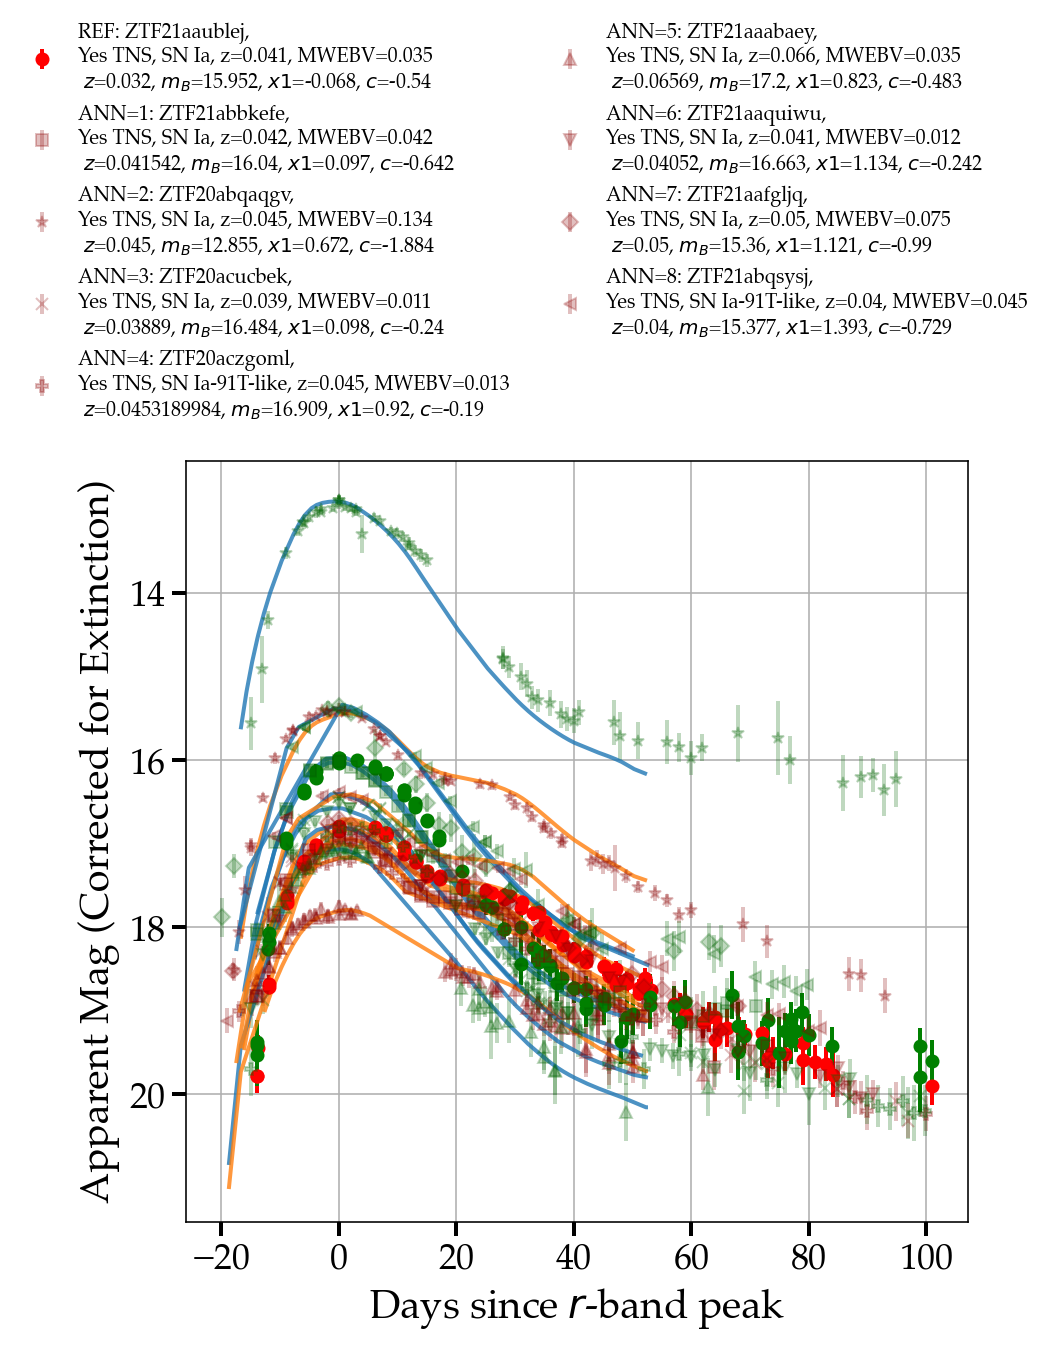

CPU times: user 10.1 s, sys: 1.11 s, total: 11.2 s
Wall time: 7.81 s


In [17]:
%%time

ztf_id_ref = "ZTF21aaublej"
mwebv = 0.035
z= 0.041
mB_l = []

host_df_ztf_id_l, host_df_ra_l, host_df_dec_l = [], [], []

ref_info = antares_client.search.get_by_ztf_object_id(ztf_object_id=ztf_id_ref)

df_ref = ref_info.timeseries.to_pandas()

has_tns_ref = dataset_bank_tns_df.loc[ztf_id_ref].has_tns.replace('_', ' ')
tns_cls_ref = dataset_bank_tns_df.loc[ztf_id_ref].tns_cls
spec_z_ref = dataset_bank_tns_df.loc[ztf_id_ref].spec_z

fig, ax = plt.subplots(figsize=(7,7))
#plt.gca().invert_yaxis()

df_ref_g = df_ref[(df_ref.ant_passband == 'g') & (~df_ref.ant_mag.isna())]
df_ref_r = df_ref[(df_ref.ant_passband == 'R') & (~df_ref.ant_mag.isna())]

mjd_idx_at_min_mag_r_ref = df_ref_r[['ant_mag']].reset_index().idxmin().ant_mag
mjd_idx_at_min_mag_g_ref = df_ref_g[['ant_mag']].reset_index().idxmin().ant_mag


# apply SALT3 fit
time_arr_ref = df_ref[(~df_ref.ant_mag.isna())].ant_mjd.values
pb_arr_ref = df_ref[(~df_ref.ant_mag.isna())].ant_passband.values
mag_arr_ref = df_ref[(~df_ref.ant_mag.isna())].ant_mag.values
flux_arr_ref = 10**(-0.4 * (mag_arr_ref-27.5))
flux_corrected_arr_ref, mag_corrected_arr_ref, A_lambda_arr = get_extinction_corrected_mags(mwebv=mwebv, magnitudes=mag_arr_ref, pbs=pb_arr_ref)
magerr_arr_ref = df_ref[(~df_ref.ant_mag.isna())].ant_magerr.values
#fluxerr_corrected_arr_ref_notreal, magerr_corrected_arr_ref, A_lambda_arr = get_extinction_corrected_mags(mwebv=mwebv, magnitudes=magerr_arr_ref, pbs=pb_arr_ref)
fluxerr_arr_ref = (magerr_arr_ref*flux_arr_ref)/1.0857
fluxerr_corrected_arr_ref = (magerr_arr_ref*flux_corrected_arr_ref)/1.0857 #flux_arr_ref * 10**(0.4 * A_lambda_arr)
lc_df_corrected_ref, param_dict_corrected_ref = return_salt3_fit_params(z=z, time_arr=time_arr_ref, pb_arr=pb_arr_ref, flux_arr=flux_corrected_arr_ref, fluxerr_arr=fluxerr_corrected_arr_ref)

# Corrected
corrected_mags_r = get_extinction_corrected_mags_pb(band_extinction_curve=calculate_band_mw_extinctions(['ztfr'])[0], 
                                                 mwebv=mwebv, magnitudes=df_ref_r.ant_mag.values)
corrected_mags_g = get_extinction_corrected_mags_pb(band_extinction_curve=calculate_band_mw_extinctions(['ztfg'])[0], 
                                                 mwebv=mwebv, magnitudes=df_ref_g.ant_mag.values)
corrected_magerrs_r = get_magerr_from_mag_pb(magnitude_errors=df_ref_r.ant_magerr, pbname='R')
corrected_magerrs_g = get_magerr_from_mag_pb(magnitude_errors=df_ref_g.ant_magerr, pbname='g')

for i,f in enumerate(np.unique(lc_df_corrected_ref['band'])):
    z= round(param_dict_corrected_ref['z'], 3)
    t0= round(param_dict_corrected_ref['t0'], 3)
    mB= round(param_dict_corrected_ref['mB'], 3)
    x1= round(param_dict_corrected_ref['x1'], 3)
    c= round(param_dict_corrected_ref['c'], 3)
    x0= round(param_dict_corrected_ref['x0'], 3)

    # careful about zpsys!
    model = sncosmo.Model(source='salt3')
    model.set(z=z,t0=param_dict_corrected_ref['t0'], x1=param_dict_corrected_ref['x1'],c=param_dict_corrected_ref['c'],x0=param_dict_corrected_ref['x0'])
    salt3flux = model.bandflux(f, lc_df_corrected_ref['time'], zp=27.5, zpsys='AB')
    salt3mag = 27.5 -2.5 * np.log10(salt3flux)
    ax.plot(lc_df_corrected_ref['time']-t0,salt3mag,color='C%i'%i, alpha=0.8, linewidth=2)

    #ax.text(0.45, 0.80, "Corrected"+'\n'+ fr"$z$={z}"+'\n'+ fr"$t_0$={t0}"+'\n'+ fr"$x1$={x1}"+'\n'+ fr"$c$={c}"+'\n'+ fr"$x_0$={x0}",#+'\n'+ fr"$m_{pkflt}$={pkmag}", 
    #        horizontalalignment='center', 
    #         verticalalignment='center', 
    #         transform=ax.transAxes,
    #         fontsize=14)
    
ax.errorbar(x=df_ref_r.ant_mjd-df_ref_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_ref], y=corrected_mags_r, yerr=corrected_magerrs_r, fmt='o', c='r',
           label=f"REF: {ztf_id_ref}, \n{has_tns_ref},\t{tns_cls_ref},\tz={round(spec_z_ref, 3)}, MWEBV={mwebv}\n $z$={z}, $m_B$={mB}, $x1$={x1}, $c$={c}")
ax.errorbar(x=df_ref_g.ant_mjd-df_ref_g.ant_mjd.iloc[mjd_idx_at_min_mag_g_ref], y=corrected_mags_g, yerr=corrected_magerrs_g, fmt='o', c='g')

mB_l.append(param_dict_corrected_ref['mB'])
print("###########")
    
    
markers = ['s', '*', 'x', 'P', '^', 'v', 'D', '<', '>', '8', 'p', 'x'] 
consts = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36] 

ztf_id_l = ["ZTF21abbkefe", "ZTF20abqaqgv", "ZTF20acucbek", "ZTF20aczgoml", "ZTF21aaabaey",
            "ZTF21aaquiwu", "ZTF21aafgljq", "ZTF21abqsysj"]
z_l = [0.041542, 0.045, 0.03889, 0.0453189984, 0.06569,
       0.04052, 0.05, 0.04]
mwebv_l = [0.042, 0.134, 0.011, 0.013, 0.035, 
           0.012, 0.075, 0.045]
spec_cls_l = ["SN Ia", "SN Ia", "SN Ia", "SN Ia", "SN Ia", "SN Ia-91T-like", "SN Ia", "SN Ia-91T-like"]


for num, (ztf_id_knn, z_knn, mwebv_knn, spec_cls_knn) in enumerate(zip(ztf_id_l, z_l, mwebv_l, spec_cls_l)):
    print(num, (ztf_id_knn, z_knn, mwebv_knn, spec_cls_knn))
    ztf_id_ann = ztf_id_knn

    try:
        l_info = antares_client.search.get_by_ztf_object_id(ztf_object_id=ztf_id_ann)
        df_knn = l_info.timeseries.to_pandas()
    except: continue  
    
    has_tns_knn = dataset_bank_tns_df.loc[ztf_id_ann].has_tns.replace('_', ' ')
    tns_cls_knn = dataset_bank_tns_df.loc[ztf_id_ann].tns_cls
    spec_z_knn = dataset_bank_tns_df.loc[ztf_id_ann].spec_z


    df_knn_g = df_knn[(df_knn.ant_passband == 'g') & (~df_knn.ant_mag.isna())]
    df_knn_r = df_knn[(df_knn.ant_passband == 'R') & (~df_knn.ant_mag.isna())]
    
    mjd_idx_at_min_mag_r_knn = df_knn_r[['ant_mag']].reset_index().idxmin().ant_mag
    mjd_idx_at_min_mag_g_knn = df_knn_g[['ant_mag']].reset_index().idxmin().ant_mag
    
    # apply SALT3 fit
    time_arr_knn = df_knn[(~df_knn.ant_mag.isna())].ant_mjd.values
    pb_arr_knn = df_knn[(~df_knn.ant_mag.isna())].ant_passband.values
    mag_arr_knn = df_knn[(~df_knn.ant_mag.isna())].ant_mag.values
    flux_arr_knn = 10**(-0.4 * (mag_arr_knn-27.5))
    flux_corrected_arr_knn, mag_corrected_arr_knn, A_lambda_arr_knn = get_extinction_corrected_mags(mwebv=mwebv_knn, magnitudes=mag_arr_knn, pbs=pb_arr_knn)
    magerr_arr_knn = df_knn[(~df_knn.ant_mag.isna())].ant_magerr.values
    fluxerr_corrected_arr_knn_notreal, magerr_corrected_arr_knn, A_lambda_arr_knn = get_extinction_corrected_mags(mwebv=mwebv_knn, magnitudes=magerr_arr_knn, pbs=pb_arr_knn)
    fluxerr_arr_knn = (magerr_arr_knn*flux_arr_knn)/1.0857
    fluxerr_corrected_arr_knn = (magerr_arr_knn*flux_corrected_arr_knn)/1.0857 #flux_arr_ref * 10**(0.4 * A_lambda_arr)
    # Corrected
    corrected_mags_r_knn = get_extinction_corrected_mags_pb(band_extinction_curve=calculate_band_mw_extinctions(['ztfr'])[0], 
                                                     mwebv=mwebv_knn, magnitudes=df_knn_r.ant_mag.values)
    corrected_mags_g_knn = get_extinction_corrected_mags_pb(band_extinction_curve=calculate_band_mw_extinctions(['ztfg'])[0], 
                                                     mwebv=mwebv_knn, magnitudes=df_knn_g.ant_mag.values)
    #print("corrected_mags_g_knn", corrected_mags_g_knn, len(corrected_mags_g_knn))
    corrected_magerrs_r_knn = get_magerr_from_mag_pb(magnitude_errors=df_knn_r.ant_magerr, pbname='R')
    corrected_magerrs_g_knn = get_magerr_from_mag_pb(magnitude_errors=df_knn_g.ant_magerr, pbname='g')
    
    if spec_cls_knn.startswith("SN Ia"):
        try:
            lc_df_corrected_knn, param_dict_corrected_knn = return_salt3_fit_params_force_z(z=z_knn, time_arr=time_arr_knn, pb_arr=pb_arr_knn, flux_arr=flux_corrected_arr_knn, fluxerr_arr=fluxerr_corrected_arr_knn)
        except: 
            print("Bad fit. Continue...")   
            ax.errorbar(x=df_knn_r.ant_mjd-df_knn_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_knn], y=corrected_mags_r_knn, yerr=corrected_magerrs_r_knn, fmt=markers[num], c='darkred', alpha=0.25, 
               label=f"ANN={num+1}: {ztf_id_knn}, \n{has_tns_knn},\t{tns_cls_knn},\tz={round(spec_z_knn, 3)}, MWEBV={mwebv_knn}\n $z$=-99, $m_B$=-99, $x1$=-99, $c$=-99")
            ax.errorbar(x=df_knn_g.ant_mjd-df_knn_g.ant_mjd.iloc[mjd_idx_at_min_mag_g_knn], y=corrected_mags_g_knn, yerr=corrected_magerrs_g_knn, fmt=markers[num], c='darkgreen', alpha=0.25)
            continue
    
    else:
        ax.errorbar(x=df_knn_r.ant_mjd-df_knn_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_knn], y=corrected_mags_r_knn, yerr=corrected_magerrs_r_knn, fmt=markers[num], c='darkred', alpha=0.25, 
                   label=f"ANN={num+1}: {ztf_id_knn}, \n{has_tns_knn},\t{tns_cls_knn},\tz={round(spec_z_knn, 3)}, MWEBV={mwebv_knn}\n $z$=-99, $m_B$=-99, $x1$=-99, $c$=-99")
        ax.errorbar(x=df_knn_g.ant_mjd-df_knn_g.ant_mjd.iloc[mjd_idx_at_min_mag_g_knn], y=corrected_mags_g_knn, yerr=corrected_magerrs_g_knn, fmt=markers[num], c='darkgreen', alpha=0.25)
    
    if spec_cls_knn.startswith("SN Ia"):
        for i,f in enumerate(np.unique(lc_df_corrected_knn['band'])):
            z= round(param_dict_corrected_knn['z'], 3)
            t0= round(param_dict_corrected_knn['t0'], 3)
            mB= round(param_dict_corrected_knn['mB'], 3)
            x1= round(param_dict_corrected_knn['x1'], 3)
            c= round(param_dict_corrected_knn['c'], 3)
            x0= round(param_dict_corrected_knn['x0'], 3)
            # careful about zpsys!
            model = sncosmo.Model(source='salt3')
            model.set(z=z_knn,t0=param_dict_corrected_knn['t0'], x1=param_dict_corrected_knn['x1'],c=param_dict_corrected_knn['c'],x0=param_dict_corrected_knn['x0'])

            salt3flux = model.bandflux(f, lc_df_corrected_knn['time'], zp=27.5, zpsys='AB')
            salt3mag = 27.5 -2.5 * np.log10(salt3flux)
            ax.plot(lc_df_corrected_knn['time']-t0,salt3mag,color='C%i'%i, alpha=0.8, linewidth=2)
            
        ax.errorbar(x=df_knn_r.ant_mjd-df_knn_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_knn], y=corrected_mags_r_knn, yerr=corrected_magerrs_r_knn, fmt=markers[num], c='darkred', alpha=0.25, 
                   label=f"ANN={num+1}: {ztf_id_knn}, \n{has_tns_knn},\t{tns_cls_knn},\tz={round(spec_z_knn, 3)}, MWEBV={mwebv_knn}\n $z$={z_knn}, $m_B$={mB}, $x1$={x1}, $c$={c}")
        ax.errorbar(x=df_knn_g.ant_mjd-df_knn_g.ant_mjd.iloc[mjd_idx_at_min_mag_g_knn], y=corrected_mags_g_knn, yerr=corrected_magerrs_g_knn, fmt=markers[num], c='darkgreen', alpha=0.25)

        mB_l.append(param_dict_corrected_knn['mB'])
        
print("mB average (after correction) is:", np.mean(mB_l))

plt.ylabel('Apparent Mag (Corrected for Extinction)')
plt.xlabel('Days since $r$-band peak')
plt.legend(frameon=False,
           bbox_to_anchor=(1.1,1.6),
           ncol=2,
           prop={'size': 10})

plt.gca().invert_yaxis()
plt.grid(True)

folder_path = f"../figures/salt3/"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

plt.savefig(f'../figures/salt3/{ztf_id_ref}_corrected_ANN0-8.jpg', dpi=300, bbox_inches='tight')
plt.show()

{'z': 0.041, 't0': 59330.48913404568, 'x0': 0.0024732202829143312, 'x1': -0.21404214661362636, 'c': 0.030128404693020187, 'mB': 17.151843001258506}
#########
0 ('ZTF21abbkefe', 0.041542, 0.042, 'SN Ia')
{'z': 0.041542, 't0': 59363.03557944432, 'x0': 0.00190247049763802, 'x1': -0.04752465603341821, 'c': 0.04939499851904796, 'mB': 17.436705173203404}
1 ('ZTF20abqaqgv', 0.045, 0.134, 'SN Ia')
{'z': 0.045, 't0': 59078.99753489861, 'x0': 0.002521054775195327, 'x1': 0.3254664372658538, 'c': 0.25755888374917063, 'mB': 17.131044295659493}
2 ('ZTF20acucbek', 0.03889, 0.011, 'SN Ia')
{'z': 0.03889, 't0': 59194.785426933915, 'x0': 0.0032483088181291947, 'x1': 0.06044460071583251, 'c': -0.05633927214027587, 'mB': 16.85585672225797}
3 ('ZTF20aczgoml', 0.0453189984, 0.013, 'SN Ia-91T-like')
{'z': 0.0453189984, 't0': 59220.50441976309, 'x0': 0.0020925644210370593, 'x1': 1.088006470689279, 'c': 0.017762981639996157, 'mB': 17.33330290768532}
4 ('ZTF21aaabaey', 0.06569, 0.035, 'SN Ia')
{'z': 0.06569, 't

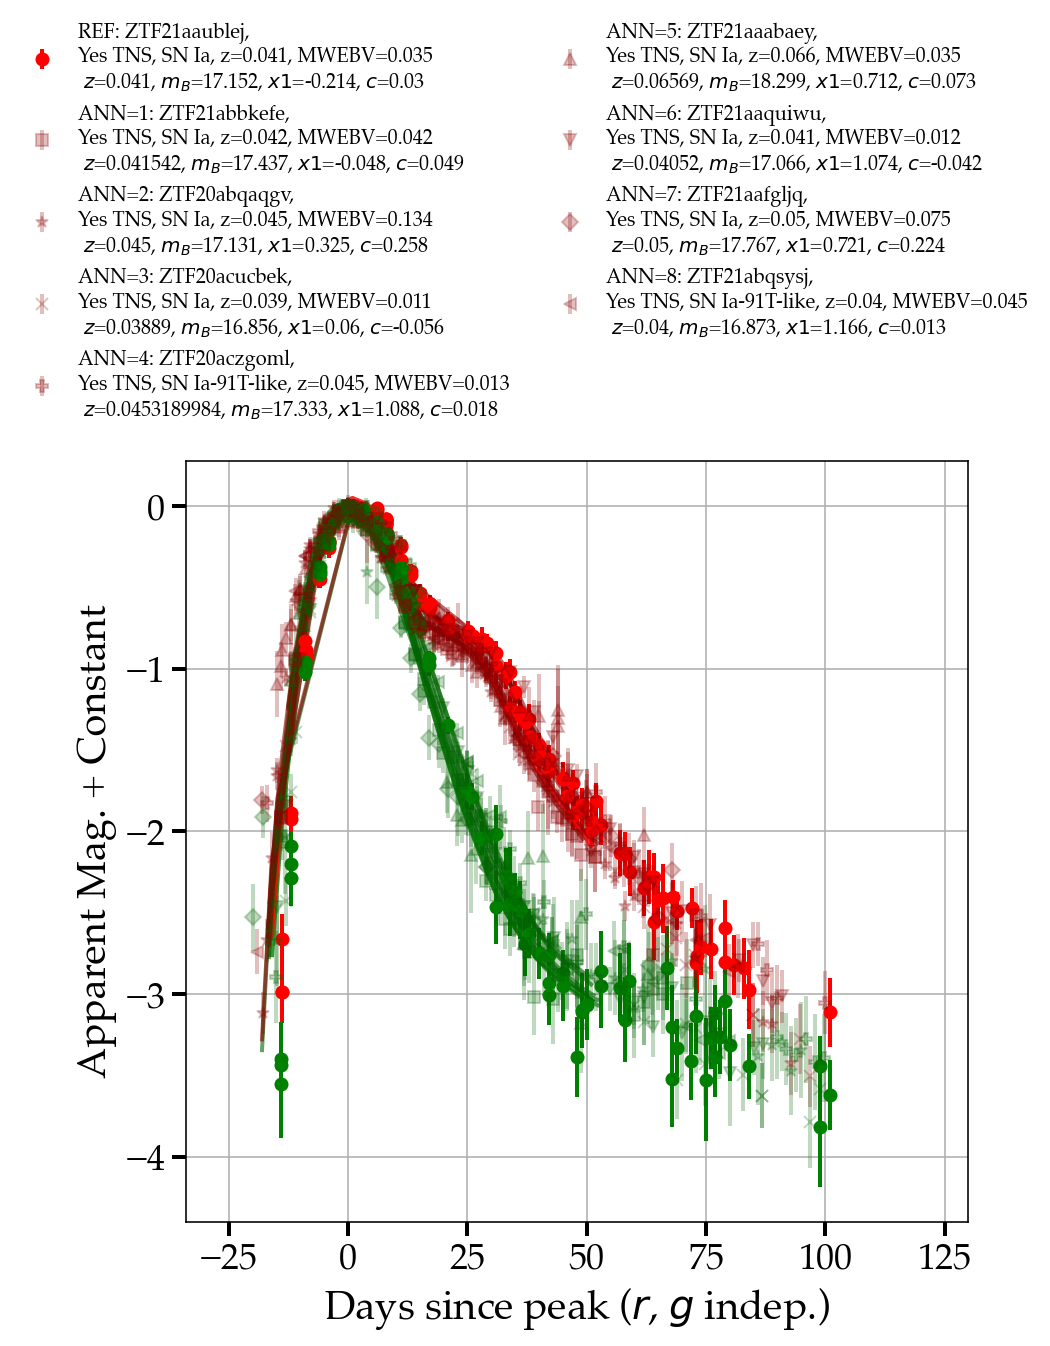

CPU times: user 8.01 s, sys: 867 ms, total: 8.87 s
Wall time: 6.61 s


In [18]:
%%time

ztf_id_ref = "ZTF21aaublej"
mwebv = 0.035
z= 0.041
mB_l = []

host_df_ztf_id_l, host_df_ra_l, host_df_dec_l = [], [], []

ref_info = antares_client.search.get_by_ztf_object_id(ztf_object_id=ztf_id_ref)

df_ref = ref_info.timeseries.to_pandas()

has_tns_ref = dataset_bank_tns_df.loc[ztf_id_ref].has_tns.replace('_', ' ')
tns_cls_ref = dataset_bank_tns_df.loc[ztf_id_ref].tns_cls
spec_z_ref = dataset_bank_tns_df.loc[ztf_id_ref].spec_z

fig, ax = plt.subplots(figsize=(7,7))
#plt.gca().invert_yaxis()

df_ref_g = df_ref[(df_ref.ant_passband == 'g') & (~df_ref.ant_mag.isna())]
df_ref_r = df_ref[(df_ref.ant_passband == 'R') & (~df_ref.ant_mag.isna())]

mjd_idx_at_min_mag_r_ref = df_ref_r[['ant_mag']].reset_index().idxmin().ant_mag
mjd_idx_at_min_mag_g_ref = df_ref_g[['ant_mag']].reset_index().idxmin().ant_mag


# apply SALT3 fit
time_arr_ref = df_ref[(~df_ref.ant_mag.isna())].ant_mjd.values
pb_arr_ref = df_ref[(~df_ref.ant_mag.isna())].ant_passband.values
mag_arr_ref = df_ref[(~df_ref.ant_mag.isna())].ant_mag.values
flux_arr_ref = 10**(-0.4 * (mag_arr_ref-27.5))
magerr_arr_ref = df_ref[(~df_ref.ant_mag.isna())].ant_magerr.values
fluxerr_arr_ref = (magerr_arr_ref*flux_arr_ref)/1.0857
lc_df_ref, param_dict_ref = return_salt3_fit_params_force_z(z=z, time_arr=time_arr_ref, pb_arr=pb_arr_ref, flux_arr=flux_arr_ref, fluxerr_arr=fluxerr_arr_ref)

ref_colors = ['g', 'r']
for i,f in enumerate(np.unique(lc_df_ref['band'])):
    if f == "ztfr": min_band_mag = df_ref_r.ant_mag.min()
    elif f == "ztfg": min_band_mag = df_ref_g.ant_mag.min()
    
    z= round(param_dict_ref['z'], 3)
    t0= round(param_dict_ref['t0'], 3)
    mB= round(param_dict_ref['mB'], 3)
    x1= round(param_dict_ref['x1'], 3)
    c= round(param_dict_ref['c'], 3)
    x0= round(param_dict_ref['x0'], 3)

    # careful about zpsys!
    model = sncosmo.Model(source='salt3')
    model.set(z=z,t0=param_dict_ref['t0'], x1=param_dict_ref['x1'],c=param_dict_ref['c'],x0=param_dict_ref['x0'])
    salt3flux = model.bandflux(f, lc_df_corrected_ref['time'], zp=27.5, zpsys='AB')
    salt3mag = 27.5 -2.5 * np.log10(salt3flux)
    ax.plot(lc_df_ref['time']-t0,min_band_mag-salt3mag,color=ref_colors[i], alpha=0.8, linewidth=3)

    #ax.text(0.45, 0.80, "Corrected"+'\n'+ fr"$z$={z}"+'\n'+ fr"$t_0$={t0}"+'\n'+ fr"$x1$={x1}"+'\n'+ fr"$c$={c}"+'\n'+ fr"$x_0$={x0}",#+'\n'+ fr"$m_{pkflt}$={pkmag}", 
    #        horizontalalignment='center', 
    #         verticalalignment='center', 
    #         transform=ax.transAxes,
    #         fontsize=14)
# UnCorrected
ax.errorbar(x=df_ref_r.ant_mjd-df_ref_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_ref], y=df_ref_r.ant_mag.min()-df_ref_r.ant_mag, yerr=df_ref_r.ant_magerr, fmt='o', c='r',
           label=f"REF: {ztf_id_ref}, \n{has_tns_ref},\t{tns_cls_ref},\tz={round(spec_z_ref, 3)}, MWEBV={mwebv}\n $z$={z}, $m_B$={mB}, $x1$={x1}, $c$={c}")
ax.errorbar(x=df_ref_g.ant_mjd-df_ref_g.ant_mjd.iloc[mjd_idx_at_min_mag_g_ref], y=df_ref_g.ant_mag.min()-df_ref_g.ant_mag, yerr=df_ref_g.ant_magerr, fmt='o', c='g')

mB_l.append(param_dict_ref['mB'])
print("#########")
    
    
markers = ['s', '*', 'x', 'P', '^', 'v', 'D', '<', '>', '8', 'p', 'x'] 
consts = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36] 

ztf_id_l = ["ZTF21abbkefe", "ZTF20abqaqgv", "ZTF20acucbek", "ZTF20aczgoml", "ZTF21aaabaey",
            "ZTF21aaquiwu", "ZTF21aafgljq", "ZTF21abqsysj"]
z_l = [0.041542, 0.045, 0.03889, 0.0453189984, 0.06569,
       0.04052, 0.05, 0.04]
mwebv_l = [0.042, 0.134, 0.011, 0.013, 0.035, 
           0.012, 0.075, 0.045]
spec_cls_l = ["SN Ia", "SN Ia", "SN Ia", "SN Ia", "SN Ia", "SN Ia-91T-like", "SN Ia", "SN Ia-91T-like"]


knn_colors = ['darkgreen', 'darkred']
for num, (ztf_id_knn, z_knn, mwebv_knn, spec_cls_knn) in enumerate(zip(ztf_id_l, z_l, mwebv_l, spec_cls_l)):
    print(num, (ztf_id_knn, z_knn, mwebv_knn, spec_cls_knn))
    ztf_id_ann = ztf_id_knn

    try:
        l_info = antares_client.search.get_by_ztf_object_id(ztf_object_id=ztf_id_ann)
        df_knn = l_info.timeseries.to_pandas()
    except: continue  
    
    has_tns_knn = dataset_bank_tns_df.loc[ztf_id_ann].has_tns.replace('_', ' ')
    tns_cls_knn = dataset_bank_tns_df.loc[ztf_id_ann].tns_cls
    spec_z_knn = dataset_bank_tns_df.loc[ztf_id_ann].spec_z


    df_knn_g = df_knn[(df_knn.ant_passband == 'g') & (~df_knn.ant_mag.isna())]
    df_knn_r = df_knn[(df_knn.ant_passband == 'R') & (~df_knn.ant_mag.isna())]
    
    mjd_idx_at_min_mag_r_knn = df_knn_r[['ant_mag']].reset_index().idxmin().ant_mag
    mjd_idx_at_min_mag_g_knn = df_knn_g[['ant_mag']].reset_index().idxmin().ant_mag
    
    # apply SALT3 fit
    time_arr_knn = df_knn[(~df_knn.ant_mag.isna())].ant_mjd.values
    pb_arr_knn = df_knn[(~df_knn.ant_mag.isna())].ant_passband.values
    mag_arr_knn = df_knn[(~df_knn.ant_mag.isna())].ant_mag.values
    flux_arr_knn = 10**(-0.4 * (mag_arr_knn-27.5))
    magerr_arr_knn = df_knn[(~df_knn.ant_mag.isna())].ant_magerr.values
    fluxerr_arr_knn = (magerr_arr_knn*flux_arr_knn)/1.0857
    
    if spec_cls_knn.startswith("SN Ia"):
        try:
            lc_df_knn, param_dict_knn = return_salt3_fit_params_force_z(z=z_knn, time_arr=time_arr_knn, pb_arr=pb_arr_knn, flux_arr=flux_arr_knn, fluxerr_arr=fluxerr_arr_knn)
        except: 
            print("Bad SALT FIT with z=spec z. Trying again with z unbounded...")
            try:
                lc_df_knn, param_dict_knn = return_salt3_fit_params(z=z_knn, time_arr=time_arr_knn, pb_arr=pb_arr_knn, flux_arr=flux_arr_knn, fluxerr_arr=fluxerr_arr_knn)
            except:
                print("Bad fit again. Continue...")
                ax.errorbar(x=df_knn_r.ant_mjd-df_knn_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_knn], y=df_knn_r.ant_mag.min()-df_knn_r.ant_mag, yerr=df_knn_r.ant_magerr, fmt=markers[num], c='darkred', alpha=0.25, 
                   label=f"ANN={num+1}: {ztf_id_knn}, \n{has_tns_knn},\t{tns_cls_knn},\tz={round(spec_z_knn, 3)}, MWEBV={mwebv_knn}\n $z$=-99, $m_B$=-99, $x1$=-99, $c$=-99")
                ax.errorbar(x=df_knn_g.ant_mjd-df_knn_g.ant_mjd.iloc[mjd_idx_at_min_mag_g_knn], y=df_knn_g.ant_mag.min()-df_knn_g.ant_mag, yerr=df_knn_g.ant_magerr, fmt=markers[num], c='darkgreen', alpha=0.25)
                continue
        # Corrected
        #ax.errorbar(x=df_knn_r.ant_mjd-df_knn_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_knn], y=df_knn_r.ant_mag.min()-df_knn_r.ant_mag, yerr=df_knn_r.ant_magerr, fmt=markers[num], c='darkred', alpha=0.25, 
        #           label=f"ANN={num+1}: {ztf_id_knn}, \n{has_tns_knn},\t{tns_cls_knn},\tz={round(spec_z_knn, 3)}, MWEBV={mwebv_knn}\n $z$={z_knn}, $t_0$={t0}, $x1$={x1}, $c$={c}")
        #ax.errorbar(x=df_knn_g.ant_mjd-df_knn_g.ant_mjd.iloc[mjd_idx_at_min_mag_g_knn], y=df_knn_g.ant_mag.min()-df_knn_g.ant_mag, yerr=df_knn_g.ant_magerr, fmt=markers[num], c='darkgreen', alpha=0.25)
        
    else: 
        ax.errorbar(x=df_knn_r.ant_mjd-df_knn_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_knn], y=df_knn_r.ant_mag.min()-df_knn_r.ant_mag, yerr=df_knn_r.ant_magerr, fmt=markers[num], c='darkred', alpha=0.25, 
                   label=f"ANN={num+1}: {ztf_id_knn}, \n{has_tns_knn},\t{tns_cls_knn},\tz={round(spec_z_knn, 3)}, MWEBV={mwebv_knn}\n $z$=-99, $m_B$=-99, $x1$=-99, $c$=-99")
        ax.errorbar(x=df_knn_g.ant_mjd-df_knn_g.ant_mjd.iloc[mjd_idx_at_min_mag_g_knn], y=df_knn_g.ant_mag.min()-df_knn_g.ant_mag, yerr=df_knn_g.ant_magerr, fmt=markers[num], c='darkgreen', alpha=0.25)
    
    if spec_cls_knn.startswith("SN Ia"):
        for i,f in enumerate(np.unique(lc_df_knn['band'])):
            if f == "ztfr": min_band_mag = df_knn_r.ant_mag.min()
            elif f == "ztfg": min_band_mag = df_knn_g.ant_mag.min()

            z= round(param_dict_knn['z'], 3)
            t0= round(param_dict_knn['t0'], 3)
            mB= round(param_dict_knn['mB'], 3)
            x1= round(param_dict_knn['x1'], 3)
            c= round(param_dict_knn['c'], 3)
            x0= round(param_dict_knn['x0'], 3)
            
            # careful about zpsys!
            model = sncosmo.Model(source='salt3')
            model.set(z=z_knn,t0=param_dict_knn['t0'], x1=param_dict_knn['x1'],c=param_dict_knn['c'],x0=param_dict_knn['x0'])

            salt3flux = model.bandflux(f, lc_df_knn['time'], zp=27.5, zpsys='AB')
            salt3mag = 27.5 -2.5 * np.log10(salt3flux)
            ax.plot(lc_df_knn['time']-t0,min_band_mag-salt3mag,color=knn_colors[i], alpha=0.6, linewidth=2)
            
#         # Create a SALT3 model using sncosmo
#         parameters = {'x0': param_dict_knn['x0'], 'x1': param_dict_knn['x1'], 'c': param_dict_knn['c'], 't0': param_dict_knn['t0']}
#         print(parameters)
#         model = sncosmo.Model(source='salt3', effects=[sncosmo.CCM89Dust()], effect_names=['mw'], effect_frames=['obs'])
#         # Set the model parameters
#         model.set(**parameters)
#         # Calculate the apparent magnitude in the B-band at the time of maximum brightness (mB)
#         mB = model.bandmag('bessellb', 'ab', [0.0])
#         print("Peak B-band magnitude (mB):", mB)
            
        ax.errorbar(x=df_knn_r.ant_mjd-df_knn_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_knn], y=df_knn_r.ant_mag.min()-df_knn_r.ant_mag, yerr=df_knn_r.ant_magerr, fmt=markers[num], c='darkred', alpha=0.25, 
                   label=f"ANN={num+1}: {ztf_id_knn}, \n{has_tns_knn},\t{tns_cls_knn},\tz={round(spec_z_knn, 3)}, MWEBV={mwebv_knn}\n $z$={z_knn}, $m_B$={mB}, $x1$={x1}, $c$={c}")
        ax.errorbar(x=df_knn_g.ant_mjd-df_knn_g.ant_mjd.iloc[mjd_idx_at_min_mag_g_knn], y=df_knn_g.ant_mag.min()-df_knn_g.ant_mag, yerr=df_knn_g.ant_magerr, fmt=markers[num], c='darkgreen', alpha=0.25)
        
        mB_l.append(param_dict_knn['mB'])

    if df_ref_r.ant_mjd.iloc[0]-df_ref_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_ref] <= 10:
            plt.xlim((df_ref_r.ant_mjd.iloc[0]-df_ref_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_ref])-20, 
                     df_ref_r.ant_mjd.iloc[-1]-df_ref_r.ant_mjd.iloc[0]+15)
    else: 
        plt.xlim(2*(df_ref_r.ant_mjd.iloc[0]-df_ref_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_ref]), 
                 df_ref_r.ant_mjd.iloc[-1]-df_ref_r.ant_mjd.iloc[0]+15)
        
print("mB average (before correction) is:", np.mean(mB_l))
        
plt.ylabel('Apparent Mag. + Constant')
#plt.xlabel('Days of event') # make iloc[0]
plt.xlabel('Days since peak ($r$, $g$ indep.)') # (need r, g to be same)
plt.legend(frameon=False,
           bbox_to_anchor=(1.1,1.60),
           ncol=2,
           prop={'size': 10})

#plt.gca().invert_yaxis()
plt.grid(True)

folder_path = f"../figures/salt3/"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

plt.savefig(f'../figures/salt3/{ztf_id_ref}_uncorrected_ANN0-8.jpg', dpi=300, bbox_inches='tight')
plt.show()

{'z': 0.045, 't0': 59078.99753489861, 'x0': 0.002521054775195327, 'x1': 0.3254664372658538, 'c': 0.25755888374917063, 'mB': 17.131044295659493}
{'z': 0.045, 't0': 59079.123138041134, 'x0': 0.12947189394667977, 'x1': 0.6719161863860329, 'c': -1.8839390828393439, 'mB': 12.854561247463682}


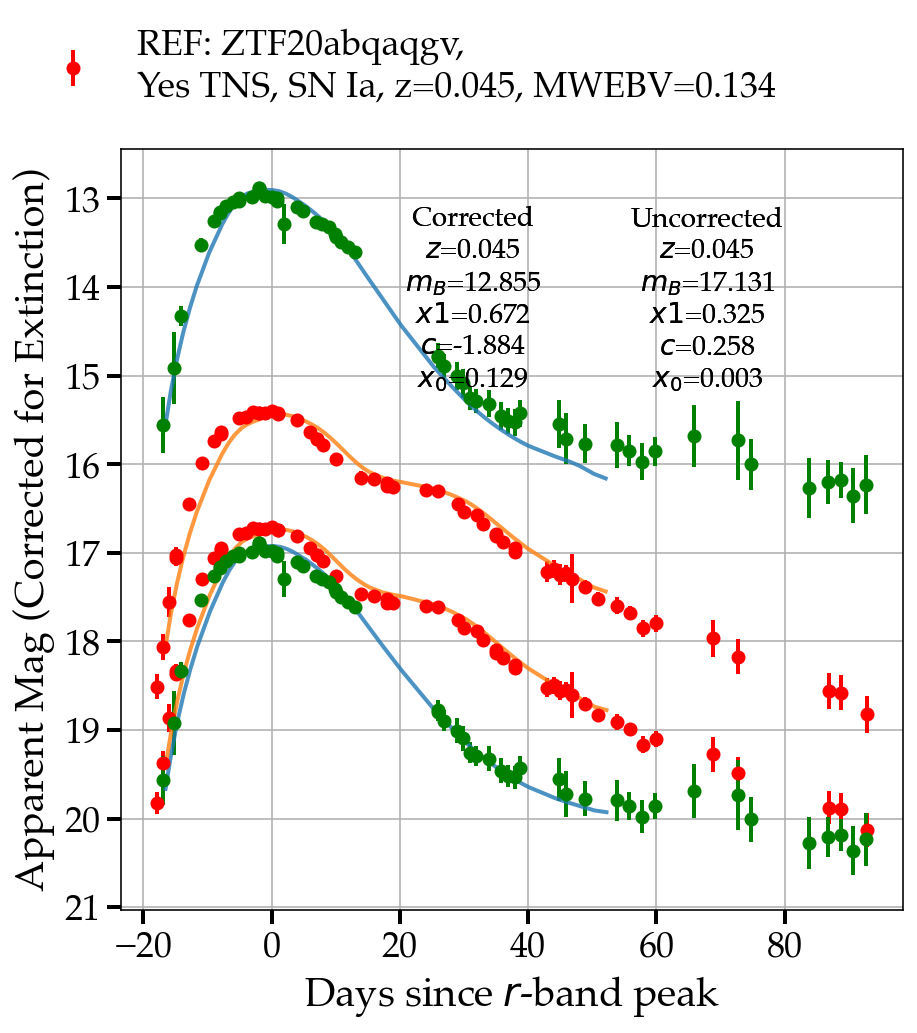

CPU times: user 2.55 s, sys: 292 ms, total: 2.85 s
Wall time: 1.5 s


In [19]:
%%time

ztf_id_ref = "ZTF20abqaqgv"
mwebv = 0.134
z= 0.045

host_df_ztf_id_l, host_df_ra_l, host_df_dec_l = [], [], []

#ztf_id_ref = ztf_id_ref #idx_arr[result_id[0]]
ref_info = antares_client.search.get_by_ztf_object_id(ztf_object_id=ztf_id_ref)

df_ref = ref_info.timeseries.to_pandas()

has_tns_ref = dataset_bank_tns_df.loc[ztf_id_ref].has_tns.replace('_', ' ')
tns_cls_ref = dataset_bank_tns_df.loc[ztf_id_ref].tns_cls
spec_z_ref = dataset_bank_tns_df.loc[ztf_id_ref].spec_z

# ra_ref = dataset_bank_orig_host_ra_dec.loc[ztf_id_ref].raMean
# dec_ref = dataset_bank_orig_host_ra_dec.loc[ztf_id_ref].decMean  

fig, ax = plt.subplots(figsize=(7,7))
#plt.gca().invert_yaxis()

df_ref_g = df_ref[(df_ref.ant_passband == 'g') & (~df_ref.ant_mag.isna())]
df_ref_r = df_ref[(df_ref.ant_passband == 'R') & (~df_ref.ant_mag.isna())]

mjd_idx_at_min_mag_r_ref = df_ref_r[['ant_mag']].reset_index().idxmin().ant_mag
mjd_idx_at_min_mag_g_ref = df_ref_g[['ant_mag']].reset_index().idxmin().ant_mag

# Uncorrected
ax.errorbar(x=df_ref_r.ant_mjd-df_ref_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_ref], y=df_ref_r.ant_mag, yerr=df_ref_r.ant_magerr, fmt='o', c='r')
ax.errorbar(x=df_ref_g.ant_mjd-df_ref_g.ant_mjd.iloc[mjd_idx_at_min_mag_r_ref], y=df_ref_g.ant_mag, yerr=df_ref_g.ant_magerr, fmt='o', c='g')

# apply SALT3 fit
time_arr_ref = df_ref[(~df_ref.ant_mag.isna())].ant_mjd.values
pb_arr_ref = df_ref[(~df_ref.ant_mag.isna())].ant_passband.values
mag_arr_ref = df_ref[(~df_ref.ant_mag.isna())].ant_mag.values
flux_arr_ref = 10**(-0.4 * (mag_arr_ref-27.5))
flux_corrected_arr_ref, mag_corrected_arr_ref, A_lambda_arr = get_extinction_corrected_mags(mwebv=mwebv, magnitudes=mag_arr_ref, pbs=pb_arr_ref)
magerr_arr_ref = df_ref[(~df_ref.ant_mag.isna())].ant_magerr.values
#fluxerr_corrected_arr_ref_notreal, magerr_corrected_arr_ref, A_lambda_arr = get_extinction_corrected_mags(mwebv=mwebv, magnitudes=magerr_arr_ref, pbs=pb_arr_ref)
fluxerr_arr_ref = (magerr_arr_ref*flux_arr_ref)/1.0857
fluxerr_corrected_arr_ref = (magerr_arr_ref*flux_corrected_arr_ref)/1.0857 #flux_arr_ref * 10**(0.4 * A_lambda_arr)
lc_df, param_dict = return_salt3_fit_params_force_z(z=z, time_arr=time_arr_ref, pb_arr=pb_arr_ref, flux_arr=flux_arr_ref, fluxerr_arr=fluxerr_arr_ref)
lc_df_corrected, param_dict_corrected = return_salt3_fit_params_force_z(z=z, time_arr=time_arr_ref, pb_arr=pb_arr_ref, flux_arr=flux_corrected_arr_ref, fluxerr_arr=fluxerr_corrected_arr_ref)


for i,f in enumerate(np.unique(lc_df['band'])):
    z= round(param_dict['z'], 3)
    t0= round(param_dict['t0'], 3)
    mB= round(param_dict['mB'], 3)
    x1= round(param_dict['x1'], 3)
    c= round(param_dict['c'], 3)
    x0= round(param_dict['x0'], 3)

    # careful about zpsys!
    model = sncosmo.Model(source='salt3')
    model.set(z=z,t0=param_dict['t0'], x1=param_dict['x1'],c=param_dict['c'],x0=param_dict['x0'])
    salt3flux = model.bandflux(f, lc_df['time'], zp=27.5, zpsys='AB')
    salt3mag = 27.5 -2.5 * np.log10(salt3flux)
    ax.plot(lc_df['time']-t0,salt3mag,color='C%i'%i, alpha=0.8, linewidth=2)

    ax.text(0.75, 0.80, "Uncorrected"+'\n'+ fr"$z$={z}"+'\n'+ fr"$m_B$={mB}"+'\n'+ fr"$x1$={x1}"+'\n'+ fr"$c$={c}"+'\n'+ fr"$x_0$={x0}",#+'\n'+ fr"$m_{pkflt}$={pkmag}", 
            horizontalalignment='center', 
             verticalalignment='center', 
             transform=ax.transAxes,
             fontsize=14)

# Corrected
corrected_mags_r = get_extinction_corrected_mags_pb(band_extinction_curve=calculate_band_mw_extinctions(['ztfr'])[0], 
                                                 mwebv=mwebv, magnitudes=df_ref_r.ant_mag.values)
corrected_mags_g = get_extinction_corrected_mags_pb(band_extinction_curve=calculate_band_mw_extinctions(['ztfg'])[0], 
                                                 mwebv=mwebv, magnitudes=df_ref_g.ant_mag.values)
#print("corrected_mags_g", corrected_mags_g, len(corrected_mags_g))
corrected_magerrs_r = get_magerr_from_mag_pb(magnitude_errors=df_ref_r.ant_magerr, pbname='R')
corrected_magerrs_g = get_magerr_from_mag_pb(magnitude_errors=df_ref_g.ant_magerr, pbname='g')

ax.errorbar(x=df_ref_r.ant_mjd-df_ref_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_ref], y=corrected_mags_r, yerr=corrected_magerrs_r, fmt='o', c='r',
           label=f'REF: {ztf_id_ref}, \n{has_tns_ref},\t{tns_cls_ref},\tz={round(spec_z_ref, 3)}, MWEBV={mwebv}')
ax.errorbar(x=df_ref_g.ant_mjd-df_ref_g.ant_mjd.iloc[mjd_idx_at_min_mag_r_ref], y=corrected_mags_g, yerr=corrected_magerrs_g, fmt='o', c='g')

for i,f in enumerate(np.unique(lc_df['band'])):
    z= round(param_dict_corrected['z'], 3)
    t0= round(param_dict_corrected['t0'], 3)
    mB= round(param_dict_corrected['mB'], 3)
    x1= round(param_dict_corrected['x1'], 3)
    c= round(param_dict_corrected['c'], 3)
    x0= round(param_dict_corrected['x0'], 3)

    # careful about zpsys!
    model = sncosmo.Model(source='salt3')
    model.set(z=z,t0=param_dict_corrected['t0'], x1=param_dict_corrected['x1'],c=param_dict_corrected['c'],x0=param_dict_corrected['x0'])
    salt3flux = model.bandflux(f, lc_df['time'], zp=27.5, zpsys='AB')
    salt3mag = 27.5 -2.5 * np.log10(salt3flux)
    ax.plot(lc_df['time']-t0,salt3mag,color='C%i'%i, alpha=0.8, linewidth=2)

    ax.text(0.45, 0.80, "Corrected"+'\n'+ fr"$z$={z}"+'\n'+ fr"$m_B$={mB}"+'\n'+ fr"$x1$={x1}"+'\n'+ fr"$c$={c}"+'\n'+ fr"$x_0$={x0}",#+'\n'+ fr"$m_{pkflt}$={pkmag}", 
            horizontalalignment='center', 
             verticalalignment='center', 
             transform=ax.transAxes,
             fontsize=14)

plt.ylabel('Apparent Mag (Corrected for Extinction)')
plt.xlabel('Days since $r$-band peak')
plt.legend(frameon=False,
           bbox_to_anchor=(0.88,1.2),
           ncol=1,
           prop={'size': 18})

plt.gca().invert_yaxis()
plt.grid(True)

folder_path = f"../figures/salt3/"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

plt.savefig(f'../figures/salt3/{ztf_id_ref}_corrected_vs_uncorrected.jpg', dpi=300, bbox_inches='tight')
plt.show()

### ZTF21aapkhsc (2021fof), z=0.04, small smudgy elliptical
mB average (before correction) is: 17.46714784229591
mB average (after correction) is: 16.676170495865986

### ZTF21aaublej (2021ixf), z=0.041, medium large elliptical
mB average (before correction) is: 17.32374506408891
mB average (after correction) is: 15.871062656409805 

^ this is mB=16.24 after correction (still brighter) if we exclude the ZTF20abqaqgv mB=12.85 outlier

## TLDR, yes we see evidence of mass step in our ANN case!